
## This will be the Capstone Project Notebook.
### In this first part, we will explore the dataset beginning with exploralory data analysis (EDA)

### Part 1 - Exploratory Data Analysis 
   <a href = '#Data Exploration and Cleaning'>1.0 Data Cleaning </a><br>
   <a href = '#assumption'>1.1 Assumptions </a><br>
   <a href = '#datatypes and new features'>1.2 Adjusting Datatypes and new features </a><br>
   <a href = '#Data Visualisation'>1.3 Data Visualisation</a><br>
### Part 2  - Data Cleaning
   <a href = '#Data Cleaning - StockCode'>2.0 Organising with StockCode</a><br>
   <a href = '#Removing cancelled transactions'>2.1 Removing cancelled transactions</a><br>
   <a href = '#stockcodes and descriptions'>2.2 Standardising StockCodes and Descriptions</a><br>
### Part 3 - Clustering Products via NLP  
   <a href = "#Placing each stock into it's categories">3.0 Clustering each product into it's categories via NLP</a><br>
   <a href = "#LDA model">3.1 Using Latent Dirichlet Allocation (LDA) Model to cluster products</a><br>
   <a href = "#Post-prediction analysis">3.2 Post-prediction analysis</a><br>
           --<a href = "#Post-prediction analysis1">3.2.1 Interactive Plot to show each key words</a><br>
           --<a href = "#Post-prediction analysis2">3.2.2 PCA Plot to show each cluster on a 2D plot</a><br>
           --<a href = "#Post-prediction analysis3">3.2.3 Word cloud on all clusters</a><br>  

### Part 4 - Merging and preparing data for classification modelling  
   <a href = "#Feature Selection">4.0 Selecting the features needed for the classification</a><br>
   <a href = "#Feature Selection1">4.1 Adding weight of purchases into clusters and reformatting information</a><br>
   <a href = "#Groupby InvoiceNo and CustomerID">4.2 Groupby InvoiceNo and CustomerID</a><br>

### Part 5 - Classifying Customers 
   <a href = "#Classifying">5.0 Classifying Customers via Agglomerative Clustering</a><br>
   <a href = "#Classifying1">5.1 Predict future customers via a Decision Tree</a><br>
          --<a href = "#Classifying2">5.1.1 Decision Tree Results (Visual and Report)</a><br>
   <a href = "#Classifying3">5.2 Conclusion</a><br>


<a id="Data Exploration and Cleaning"></a>
1.0 Data Cleaning

In [135]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statistics import mode
from scipy.stats import mode
from matplotlib.pyplot import get_cmap

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
import random as rand
import pyLDAvis.sklearn
from wordcloud import WordCloud

import itertools
from itertools import cycle
from collections import Counter

from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import multilabel_confusion_matrix

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random

In [2]:
data = pd.read_csv("./data/data.csv", encoding = 'unicode_escape')

In [3]:
#exploring the dataset
def explore(df):
    print(df.shape)
    print("")
    print(df.head())
    print("")
    print(df.dtypes)
    print("")
    print(df.isnull().sum())
    print("")
    print(df.describe())
    
explore(data)

(541909, 8)

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object



In [4]:
data.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom

<a id="assumption"></a>
1.1 Assumptions <br>
The NULL values only exist in Description (1454 rows) and CustomerID (135080 rows) <br>
Hence, we will use the following 2 assumptions to remove them.
#### Assumption 1: Since the null descriptions does not have a UnitPrice tagged to it, we will assume it uncompleted transactions and will remove these rows

#### Assumption 2: We will assume the missing customer ID as new, unregistered customers of the e-commence site and will assign a customer ID for them (Also we should keep this data since it contributes to 25% of the dataset)

In [5]:
#Assumption 1
print(data.shape)
data = data.drop_duplicates()
print(data.shape)
#number of duplicated entries: 5268

(541909, 8)
(536641, 8)


In [6]:
#Followed up with Assumption 1
#All Description with Null values also has UnitPrice = 0, we will remove it later 
data[(data["Description"].isnull()) & (data['UnitPrice'] != 0.0)].shape

(0, 8)

In [7]:
#Assumption 2
print(data["Description"].isnull().sum()/len(data))
#There are 25% of all items transacted without a CustomerID
print(data["CustomerID"].isnull().sum()/len(data))

0.0027094463524031894
0.2516337737891812


In [8]:
#min data.CustomerID starts from 12,346. We will assign 1 for new, unregistered customers
#then we will replace them with a 6 digits number to uniquely identify each of them
#therefore CustomerID == 5digits (Registered), 6digits (Non-Registered) 
data['CustomerID'] = data['CustomerID'].replace(np.nan, 1, regex=True)

custom = 100000
for i in tqdm(range(len(data))):
    if data['CustomerID'].iloc[i] == 1:
        data['CustomerID'].iloc[i] = custom
        custom += 1

  0%|          | 0/536641 [00:00<?, ?it/s]/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:202: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 536641/536641 [00:23<00:00, 23132.76it/s]


In [9]:
#Back to Assumption 1, now that we replace null values from CustomerID,
#we will drop the null values from description
print(data.shape)
data.dropna(axis = 0, inplace = True)
print(data.shape)
#Removed 1454 rows

(536641, 8)
(535187, 8)


In [10]:
#all null values are removed
data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

<a id="datatypes and new features"></a>
1.2 Adjusting Datatypes and new features<br>
### Next, we will change the datatypes

 - InvoiceNo
        - Some invoice numbers has a "C" which denotes a cancelled transaction
        - To label this, we will add a new column: Purchased = 1, Cancelled = 0
        - Then remove C from the Invoice No and change type to integers
 
 
 - Invoice date should be changed to date time
 - Customer ID should be int not floats
 - Countries 
         - List the top countries
         - Change to UK = 1, Not UK = 0

### and also add a new feature
 - TotalPrice = Quantity * UnitPrice

In [11]:
#There are three rows which are for BAD DEBT adjustments.
#All three rows are Non-Registered
#dropping these 3 rows since it is isolated and does not affect other transactions
data[data.InvoiceNo.str.contains("A")]
data.drop([299982,299983,299984], inplace = True)

In [12]:
data['InvoiceType'] = data['InvoiceNo'].str.contains("C")
data['InvoiceType'] = data['InvoiceType'].apply(lambda i:1 if i == False else 0)

#data.InvoiceNo contains letters C
print(data[data.InvoiceNo.str.contains("C")].shape)

#changing them away
data['InvoiceNo'] = data['InvoiceNo'].replace('C', '', regex=True)

#double check that all InvoiceNo that used to contain C has quantity below 0 (ie refund/cancelled purchase)
data[(data['InvoiceType'] == 0) & (data['Quantity'] > 0)].count()

(9251, 9)


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
InvoiceType    0
dtype: int64

In [13]:
#Changing the datatypes to it's appropriate types
data.InvoiceNo = data.InvoiceNo.astype(int)
data.InvoiceDate = pd.to_datetime(data.InvoiceDate)
data.CustomerID = data.CustomerID.astype(int)

#Change CountryType to UK and non-UK
data['CountryType'] = data.Country.apply(lambda i:1 if i == 'United Kingdom' else 0)

#Creating a new column: TotalPrice = Quantity * UnitPrice
data["TotalPrice"]=data["Quantity"]*data["UnitPrice"]

In [14]:
explore(data)

(535184, 11)

   InvoiceNo StockCode                          Description  Quantity  \
0     536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1     536365     71053                  WHITE METAL LANTERN         6   
2     536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3     536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4     536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  InvoiceType  \
0 2010-12-01 08:26:00       2.55       17850  United Kingdom            1   
1 2010-12-01 08:26:00       3.39       17850  United Kingdom            1   
2 2010-12-01 08:26:00       2.75       17850  United Kingdom            1   
3 2010-12-01 08:26:00       3.39       17850  United Kingdom            1   
4 2010-12-01 08:26:00       3.39       17850  United Kingdom            1   

   CountryType  TotalPrice  
0            1       15.30  
1            1       20.34

In [15]:
#Saving this file first
data.to_csv('./data/data1.csv',index=False)

<a id="Data Visualisation"></a>
1.3 Data Visualisation<br>

### Next, let's try to visualise some of the data we have

In [16]:
data = pd.read_csv("./data/data1.csv", encoding = 'unicode_escape')

In [17]:
data.head(2)

InvoiceNo StockCode                         Description  Quantity  \
0     536365    85123A  WHITE HANGING HEART T-LIGHT HOLDER         6   
1     536365     71053                 WHITE METAL LANTERN         6   

           InvoiceDate  UnitPrice  CustomerID         Country  InvoiceType  \
0  2010-12-01 08:26:00       2.55       17850  United Kingdom            1   
1  2010-12-01 08:26:00       3.39       17850  United Kingdom            1   

   CountryType  TotalPrice  
0            1       15.30  
1            1       20.34

### Top 10 Countries by transactions:

|Country | Transaction |
|--------|-------------|
|United Kingdom|488843|
|Germany|9480|
|France|8541|
|EIRE(aka Ireland)|8184|
|Spain|2528|
|Netherlands|2371|
|Belgium|2069|
|Switzerland|1994|
|Portugal|1510|
|Australia|1258|

In [18]:
#Top 10 countries: 
data[['InvoiceNo','Country']].groupby("Country").count().sort_values(by='InvoiceNo', ascending= False).head(10)

InvoiceNo
Country                  
United Kingdom     488843
Germany              9480
France               8541
EIRE                 8184
Spain                2528
Netherlands          2371
Belgium              2069
Switzerland          1994
Portugal             1510
Australia            1258

In [19]:
print("Percentage of Invoice from UK: {}".format(488843/len(data)*100))

Percentage of Invoice from UK: 91.34110885228259


### Transaction / Cancellation Rates

In [20]:
data[['InvoiceType','Country']].groupby("InvoiceType").count().sort_values(by='Country', ascending= False)
#Most of the transactions are completed

Country
InvoiceType         
1             525933
0               9251

In [21]:
print("Percentage of Cancellation: {}".format(9251/len(data)*100))
#Most of them are completed transactions, minority cancellations

Percentage of Cancellation: 1.7285643815958625


#### Below are some insights on Purchase Quantities and TotalPrice paid

##### Within each item purchased (each row)
    - Most people tend to buy just a piece of an unique item
    - Most people spend about $10 - $15 on each item
##### and also within each invoice number
    -In each transaction, most customers are also buying just one item
    -but by median their basket size increased to about 150 items
    
    -In each transaction, most customers are paying about $15 dollars
    - but median basket price increased to about $300 dollars

In [22]:
print('Mean Quantity purchased per item: ',data.Quantity[(data['Quantity']>0)].mean())
print('Median Quantity purchased per item:',data.Quantity[(data['Quantity']>0)].median())
print('Mode Quantity purchased per item: ',mode(data.Quantity[(data['Quantity']>0)]))

#Because of the strong outlier, the mean is overly inflated
#Most people tend to buy just a piece of an unique item

Mean Quantity purchased per item:  10.681078828224466
Median Quantity purchased per item: 4.0
Mode Quantity purchased per item:  ModeResult(mode=array([1]), count=array([144366]))


In [23]:
print('Mean TotalPrice purchased($) per item: ',data.TotalPrice[(data['TotalPrice']>0)].mean())
print('Median TotalPrice purchased($) per item:',data.TotalPrice[(data['TotalPrice']>0)].median())
print('Mode TotalPrice purchased($) per item: ',mode(data.TotalPrice[(data['TotalPrice']>0)]))

#Most people spend about $10 - $15 on each item

Mean TotalPrice purchased($) per item:  20.25436196290567
Median TotalPrice purchased($) per item: 9.92
Mode TotalPrice purchased($) per item:  ModeResult(mode=array([15.]), count=array([20211]))


In [24]:
data2 = data[(data['Quantity']>0) & (data['TotalPrice']>0)]

In [25]:
#create another df for Quantity > 0 
#groupby the below to find in EACH TRANSACTION, how many items they buy
#and the cell below, to find in each transaction, how much they pay - basket size/transaction

print('Per Invoice basis, each customer buys on average', 
      data2[['InvoiceNo','Quantity']].groupby("InvoiceNo").sum().sort_values(by='Quantity', ascending= False).mean(),
      'items')
print('Per Invoice basis, each customer buys at median', 
      data2[['InvoiceNo','Quantity']].groupby("InvoiceNo").sum().sort_values(by='Quantity', ascending= False).median(),
     'items')

print('Per Invoice basis, most customers buys', 
      mode(data2[['InvoiceNo','Quantity']].groupby("InvoiceNo").sum().sort_values(by='Quantity', ascending= False)),
     'items')

#In each transaction, most customers are also buying just one item
#but by median their basket size increased to about 150 items

Per Invoice basis, each customer buys on average Quantity    279.193296
dtype: float64 items
Per Invoice basis, each customer buys at median Quantity    150.0
dtype: float64 items
Per Invoice basis, most customers buys ModeResult(mode=array([[1]]), count=array([[357]])) items


In [26]:
print('Per Invoice basis, each customer pays on average($):', 
      data2[['InvoiceNo','TotalPrice']].groupby("InvoiceNo").sum().sort_values(by='TotalPrice', ascending= False).mean(),
      'items')
print('Per Invoice basis, each customer pays at median ($):', 
      data2[['InvoiceNo','TotalPrice']].groupby("InvoiceNo").sum().sort_values(by='TotalPrice', ascending= False).median(),
     'items')

print('Per Invoice basis, most customers pays ($):', 
      mode(data2[['InvoiceNo','TotalPrice']].groupby("InvoiceNo").sum().sort_values(by='TotalPrice', ascending= False)),
     'items')

#In each transaction, most customers are paying about $15
#but median basket price increased to about $303.30

Per Invoice basis, each customer pays on average($): TotalPrice    532.644358
dtype: float64 items
Per Invoice basis, each customer pays at median ($): TotalPrice    303.3
dtype: float64 items
Per Invoice basis, most customers pays ($): ModeResult(mode=array([[15.]]), count=array([[57]])) items


Text(0, 0.5, 'Quantity')

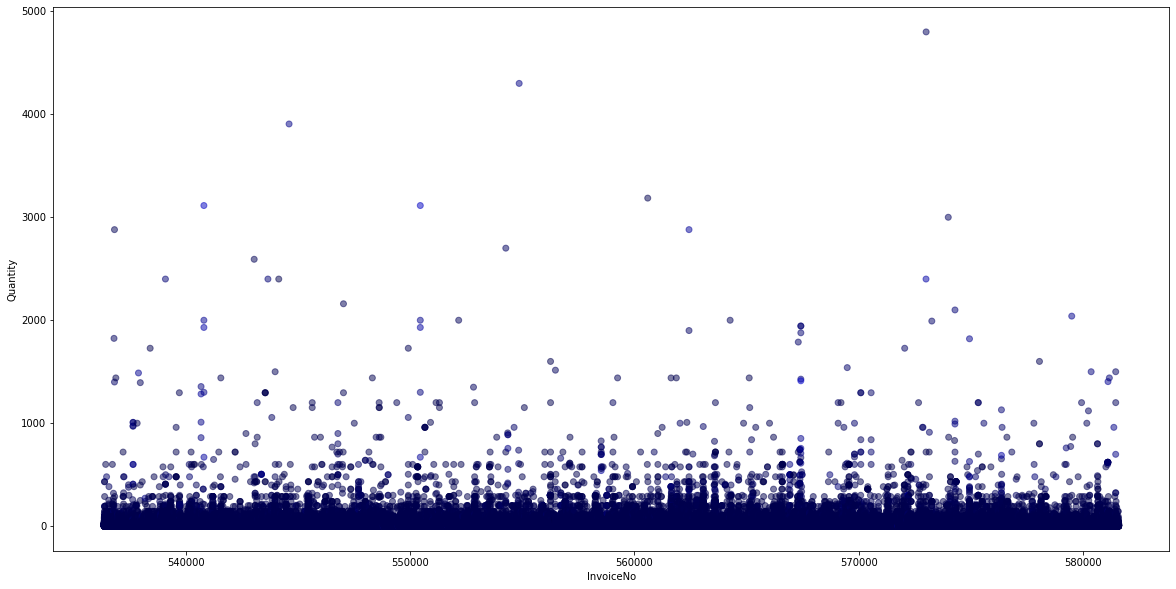

In [27]:
#After filtering out the outliers, we are seeing the quantity of goods people are buying
#it seems like quite a number of purchases are in bulk

data3=data2[data2['Quantity']<10000]
plt.figure(figsize=(20,10))
plt.scatter(x=data3["InvoiceNo"], y=data3["Quantity"], alpha = 0.5, c=data3["TotalPrice"], cmap='seismic')
plt.xlabel('InvoiceNo')
plt.ylabel('Quantity')

Text(0, 0.5, 'TotalPrice')

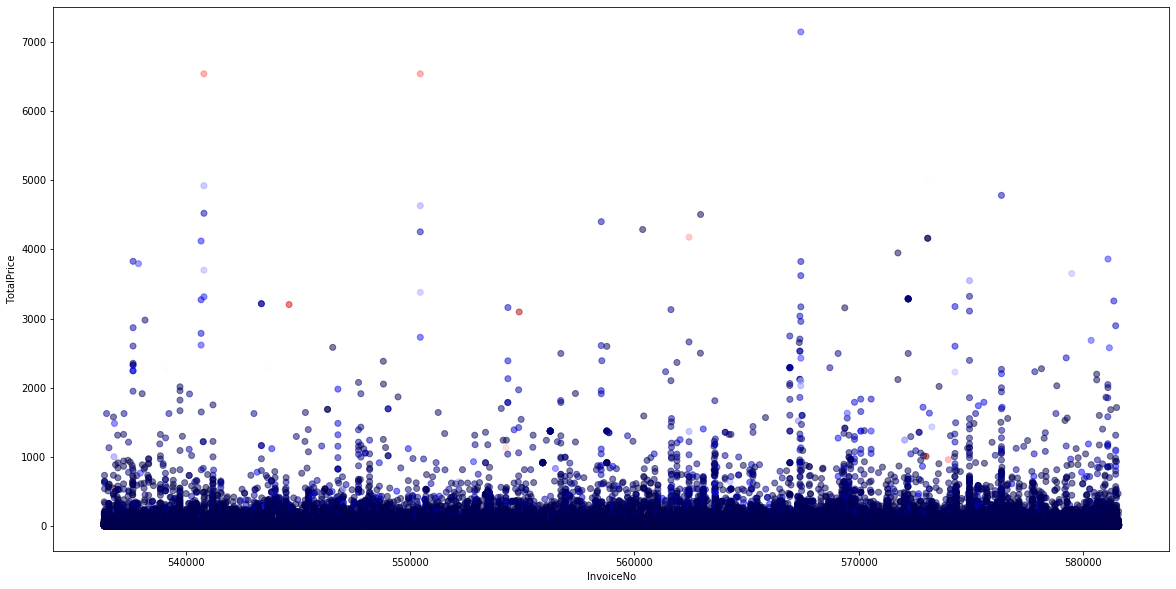

In [28]:
#After filtering out the outliers, we are seeing the price of goods people are buying
#while majority of the purchases are below $500, there are still quite a number of them buying goods over $1000
#Colour in Red represents higher quantity

data3=data2[data2['TotalPrice']<8000]
plt.figure(figsize=(20,10))
plt.scatter(x=data3["InvoiceNo"],y=data3["TotalPrice"], alpha = 0.5, c=data3["Quantity"], cmap='seismic')
plt.xlabel('InvoiceNo')
plt.ylabel('TotalPrice')

#### We will then move to investigate the time component of the dataset

In [29]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [30]:
data['Date'] = data['InvoiceDate'].dt.date
data['Year'] = data['InvoiceDate'].dt.year
data['Month'] = data['InvoiceDate'].dt.month
data['Day'] = data['InvoiceDate'].dt.day
data['Weekday'] = data['InvoiceDate'].dt.weekday
data['Hour'] = data['InvoiceDate'].dt.hour

#Weekday: {'0':Monday ... {6}:Sunday}

/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



Text(0.5, 1.0, 'Transactions over the year')

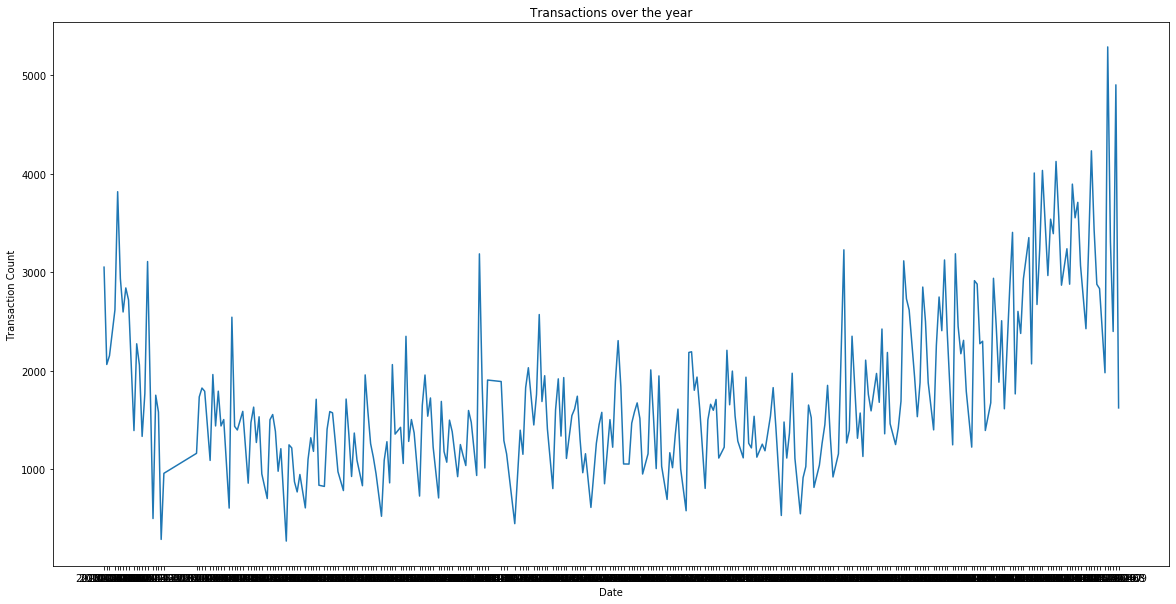

In [31]:
plt.figure(figsize=(20,10))
plt.plot(data.groupby('Date').count().InvoiceNo)
plt.xticks(data.Date.unique())
plt.ylabel('Transaction Count')
plt.xlabel('Date')
plt.title('Transactions over the year')

#Mostly random, increasing trend towards the end of the year

Text(0.5, 1.0, 'Transactions over the year, by months')

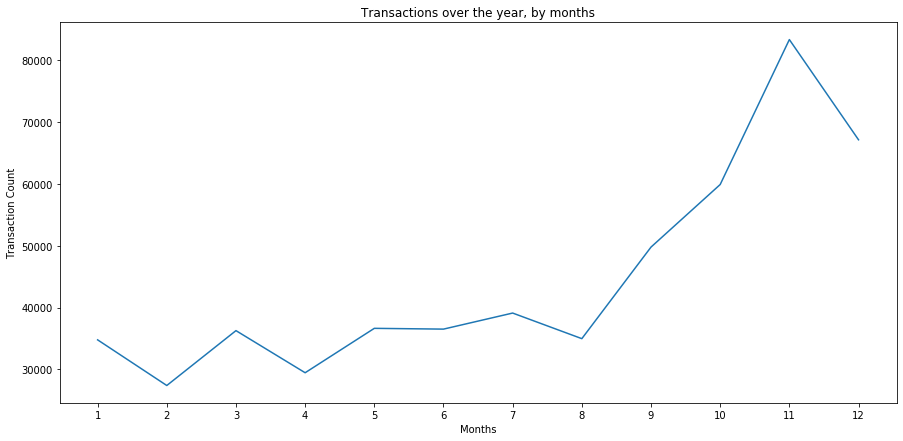

In [32]:
plt.figure(figsize=(15,7))
plt.plot(data.groupby('Month').count().InvoiceNo)
plt.xticks(data.Month.unique())
plt.ylabel('Transaction Count')
plt.xlabel('Months')
plt.title('Transactions over the year, by months')

#Transactions picking up over the second half of the year

{0, 1, 2, 3, 4, 6}

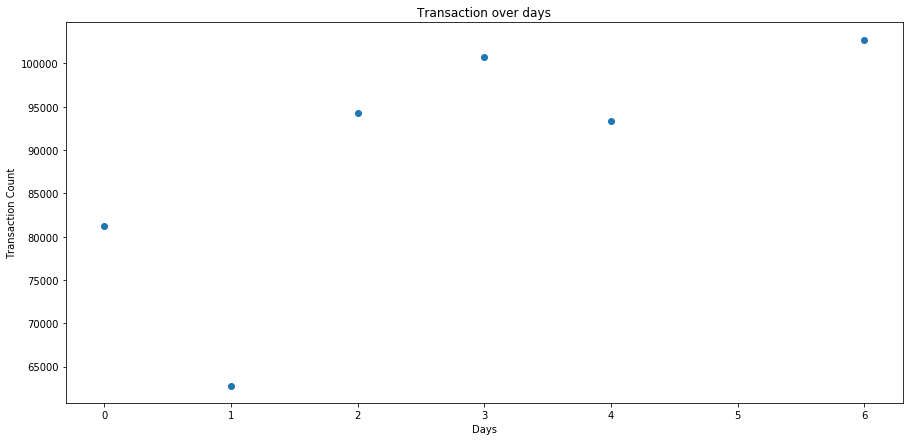

In [33]:
plt.figure(figsize=(15,7))
plt.scatter(y=data.groupby('Weekday').count().InvoiceNo, x=data.Weekday.unique())
plt.ylabel('Transaction Count')
plt.xlabel('Days')
plt.title('Transaction over days')

set(data.Weekday)

#There are no transactions on Saturdays for the whole year, could be companies not buying in bulk on that day or no one to approve the order
#Tues has the lowest transactions during the week
#Transactions starts to pick up on Wednesdays through to Sundays
#Thursday has the second highest transaction after Sundays

{6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}

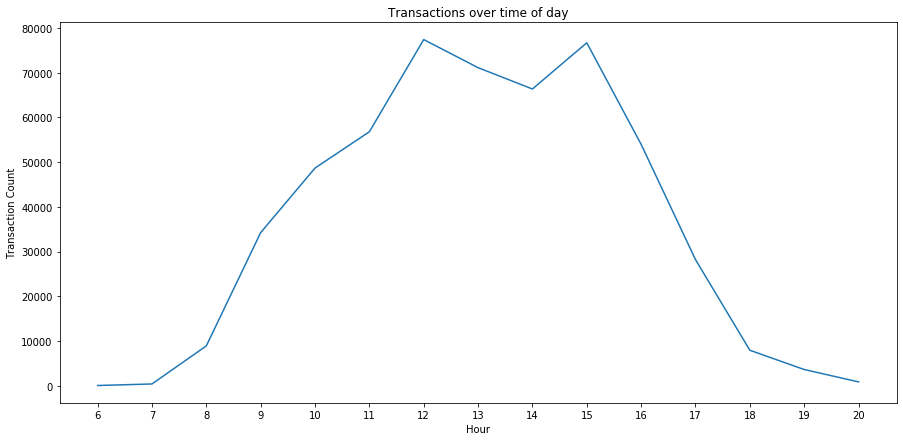

In [34]:
plt.figure(figsize=(15,7))
plt.plot(data.groupby('Hour').count().InvoiceNo)
plt.xticks(data.Hour.unique())
plt.ylabel('Transaction Count')
plt.xlabel('Hour')
plt.title('Transactions over time of day')

set(data.Hour)

#slow and steady rise of transactions from 7am onwards till noon
#peaks over during lunch hours through to 4pm
#and declines over the next 4hours till 8pm
#Orders during working hours

<a id="Data Cleaning - StockCode"></a>
2.0 Organising StockCodes
### In this section, we will try to understand more from the "StockCode" column.
### Apart from the SKU codes (The 5 digit numbers), there is also an extension alphabet and also some with only text

In [35]:
stockcode = data['StockCode'].astype(str)
special_stockcodes = []
for i in range(len(stockcode )):
    removed = re.sub(r'\d+', '', stockcode [i])
    if len(removed)>1 == True:
        special_stockcodes.append(removed)

print(set(special_stockcodes))
print(len(special_stockcodes))
#This will give me all the special StockCodes in each transaction

{'AMAZONFEE', 'GR', 'CRUK', 'DCGSSGIRL', 'DCGSSBOY', 'LP', 'bl', 'POST', 'DCGS', 'PADS', 'BL', 'DOT', 'gift__', 'BANK CHARGES'}
2512


| StockCode Extension | Meaning |
|------------|---------|
|BL          | Extension from StockCode|
|bl          | Extension from StockCode (lower case of the above)|
|DCGS | Common item for sale |
|DCGSSGIRL | Common item for sale - ladies range|
|DCDSSBOY | Common item for sale - gentlemen range|
|LP          | Unsaleable, destroyed|
|GR          | Unsaleable, destroyed|
|PADS        | Free paddings that comes along cushion purchased|
|S | Samples|
|Gift | Gift Vouchers 10, 20, 30, 40 dollars |
|Bank Charges| Bank charges for payment mode|
|POST        | Postage fees|
|C2 | Carriage |
|M | Manual |
|DOT         | Dotcom postage|
|AMAZONFEE   | Amazon fee|
|CRUK | Cancer Research UK commission |





<a id="Removing cancelled transactions"></a>
2.1 Removing cancelled transactions
## Removing cancelled transactions:
### We will remove transactions that are purchased and cancelled so that we can focus on the transactions that are purely purchased only

#### To do this, we will split the dataset into:
    - df a = Refund OR Negative Quantity items (indicating that items has been refunded)
    - df b = Purchase OR Positive Quantity items (indicating that items has been purchased)
    
There will be 6 different scenarios/outcomes by comparing different aspects of the transaction.

Step 1: [Scenario A] <br> 
    Comparing Customer ID from df A and df B. <br>
    If Customer ID from df A does not match any from df B. <br>
    This indicates that the customer has been refunded for PRIOR purchases, the customer has NOT returned to the site. <br>
    If the Customer ID from df A matches df B, proceed to step 2.

Step 2: [Scenario B] <br>
    We will match the StockCode on purchases bought in df B vs the refund from df A. <br>
    If StockCode from the refunded df A does not match any from the purchases in df B. <br>
    This indicates that the customer has been refunded for PRIOR purchases, the customer has RETURNED to purchase a different item. <br>
    If the StockCode from df A matches df B, proceed to step 3.
    
Step 3: [Scenario C] <br>
    We will compare the TIME of purchase for the refund in df A against the purchase in df B. <br>
    If the refund time is earlier than the purchase time. <br>
    This indicates that the customer has been refunded for PRIOR purchases, the customer has RETURNED to purchase the same item. <br>
    If the time of purchase is earlier than the refund, proceed to step 4. <br>
     
Step 4: [Scenario D] <br>
    Purchase Quantity vs Refund Quantity <br>
    If both of this value are equal, we will treat this as a FULL REFUND <br>
    If the purchase quantity is not equal to refund quantity, proceed to step 5. <br>
    
Step 5: [Scenario E] <br>
    Purchase Quantity more than Refund Quantity <br>
    If purchase quantity is higher, we will treat this as a PARTIAL REFUND <br>
    If the purchase quantity less than refund quantity, proceed to step 6. <br>
    
Step 6: [Scenario F] <br>
    Lastly, if the purchase quantity less than refund quantity.<br>
    This indicates that the customer has been refunded for PRIOR purchases, the customer has RETURNED to purchase the same item, but lower quantity.<br>
    

For FULL REFUND, we will treat the transaction as if it didn't exist, so we will remove both the negative quantity and it's respective positive purchase row.<br>
For PARTIAL REFUND, we will remove the row from Refund df and manually adjust the purchased quantities to reflect the actual purchase from the customer. <br>
FOR all other scenarios, remove row from Refund df

In [36]:
#first we will check the number of rows in the REFUND database
print(sum(data['Quantity']<0))
#total rows
print(data.shape)

#examine some rows with quantity below 0 
data[data['Quantity']<0].head()

9725
(535184, 17)


InvoiceNo StockCode                       Description  Quantity  \
141     536379         D                          Discount        -1   
154     536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235     536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236     536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237     536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   

            InvoiceDate  UnitPrice  CustomerID         Country  InvoiceType  \
141 2010-12-01 09:41:00      27.50       14527  United Kingdom            0   
154 2010-12-01 09:49:00       4.65       15311  United Kingdom            0   
235 2010-12-01 10:24:00       1.65       17548  United Kingdom            0   
236 2010-12-01 10:24:00       0.29       17548  United Kingdom            0   
237 2010-12-01 10:24:00       0.29       17548  United Kingdom            0   

     CountryType  TotalPrice        Date  Year  Month  Day  Weekday  Hour  
141            1      -27.50  2010-12-01  2010     12    1        2     9  
154            1       -4.65  2010-12-01  2010     12    1        2     9  
235            1      -19.80  2010-12-01  2010     12    1        2    10  
236            1       -6.96  2010-12-01  2010     12    1        2    10  
237            1       -6.96  2010-12-01  2010     12    1        2    10

In [37]:
#REFUND and PURCHASE DATAFRAME split
a = data[data['Quantity']<0] #-ve quantity goods
b = data[data['Quantity']>0] #+ve quantity goods
print(a.shape)
print(b.shape)

(9725, 17)
(525459, 17)


The following cell will take come time to complete, you can grab coffee if you are running this. <br>
It will filter what the long text was saying earlier, to remove the refunded transactions.

In [38]:
#SA = scenario A etc.
#6 scenarios in total
cancellation_without_prior_purchase_SA = 0
cancellation_without_prior_purchase_SB = 0
cancellation_without_prior_purchase_SC = 0
full_refund = 0 #scenario D
partial_refund = 0 #scenario E
cancellation_without_prior_purchase_SF = 0

for i in tqdm(range(len(a))):
    try:
        index_test = list(b.iloc[:,6]).index(a.iloc[0,6])  #if the CustomerID is in df A (df purchased)
        c = b[b['CustomerID'] == a.iloc[0,6]]              #show customer transaction history the df purchased
        
        if len(c[c['StockCode'] == a.iloc[0,1]]) == 0:    #if there isn't a previous record of purchase of that product
            a.drop(a.index[0], inplace = True)            #Scenario B
            cancellation_without_prior_purchase_SB += 1
        else:
            d=c[c['StockCode'] == a.iloc[0,1]]            #all purchase records of the same stockcode
            z=0
            d['diff_in_quant']=0
            index_=[]
            
            for j in range(len(d)):
                if (d.iloc[j,4] <= a.iloc[0,4]) == True:  #if purchase date/time earlier than refund date/time
                    z += 1                        
                    d['diff_in_quant'][j] = d.iloc[j,3] + a.iloc[0,3]
                    index_.append(d.index[j])
                else:
                    z = 0
                    
            if z == 0:                                   #purchase date/time later than refund date/time
                a.drop(a.index[i], inplace = True)       #Scenario C
                cancellation_without_prior_purchase_SC += 1 
            else:
                if d['diff_in_quant'][j] == 0:           #purchase Quantity = refund Quantity
                    a.drop(a.index[0], inplace = True)
                    b.drop(index_, inplace=True)         #Scenario D
                    full_refund += 1
                elif d['diff_in_quant'][j] > 0:          #purchase Quantity != refund Quantity
                    a.drop(a.index[0], inplace = True)   #Scenario E
                    b['Quantity'].loc[index_] = d['diff_in_quant'].iloc[j]  
                                                         #change the purchased quantity = diff in quant
                    partial_refund += 1
                else:
                    a.drop(a.index[0], inplace = True)
                    cancellation_without_prior_purchase_SF += 1 #Scenario F
                    
    
    except (ValueError, IndexError, KeyError):          #Error will occur if customer ID does not match in A & B
        try:                                            #OR when all rows in A are deleted
            a.drop(a.index[0], inplace = True)          #Scenario A
            cancellation_without_prior_purchase_SA += 1
        except (IndexError):
            print('A is null')

  0%|          | 0/9725 [00:00<?, ?it/s]/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 50%|█████     | 4867/9725 [04:08<04:50, 16.72it/s]/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

In [39]:
#checking if it falls nicely into each buckets
print('Scenario A: ', cancellation_without_prior_purchase_SA)
print('Scenario B: ', cancellation_without_prior_purchase_SB)
print('Scenario C: ', cancellation_without_prior_purchase_SC)
print('Scenario D: ', full_refund)
print('Scenario E: ', partial_refund)
print('Scenario F: ', cancellation_without_prior_purchase_SF)
print('a after:',a.shape)
print('b after:',b.shape)

Scenario A:  3803
Scenario B:  429
Scenario C:  4862
Scenario D:  188
Scenario E:  394
Scenario F:  49
a after: (0, 17)
b after: (524944, 17)


From the above, we can conclude that most of the transactions are refunds based on prior purchases to the dataset. <br>
There are only 197 full refunds (or error purchases)
and 399 partial refunds out of 9725 refund rows

Text(0, 0.5, 'Quantity')

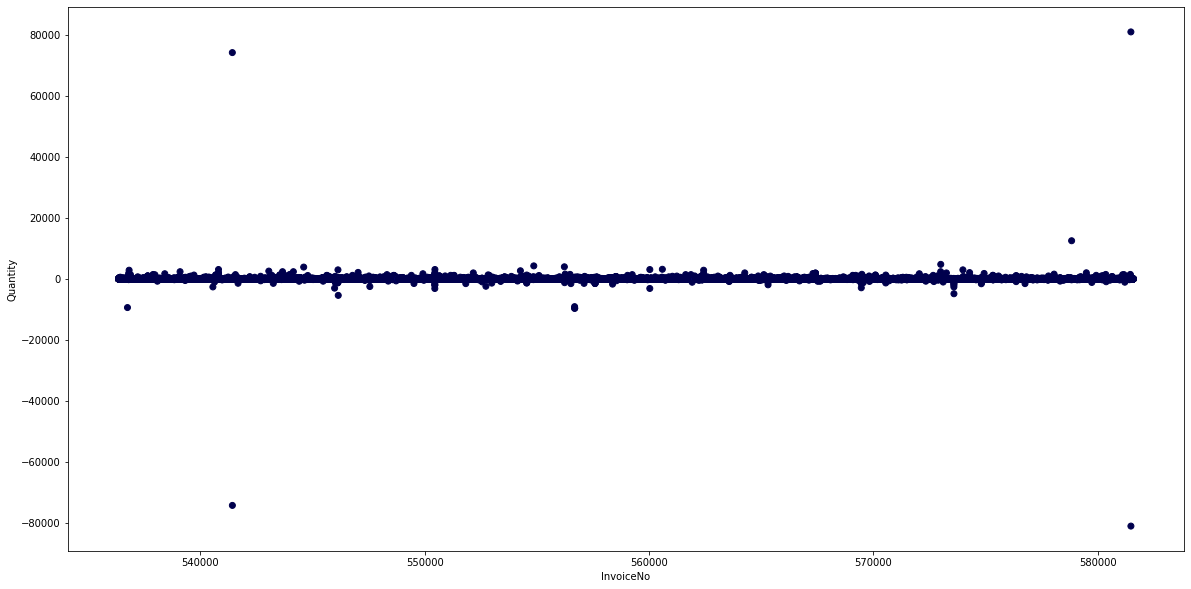

In [40]:
#Before: Quantities are spread across positives and negative regions with huge outliers
plt.figure(figsize=(20,10))
plt.scatter(x=data["InvoiceNo"], y=data["Quantity"], c=data["UnitPrice"], cmap='seismic')
plt.xlabel('InvoiceNo')
plt.ylabel('Quantity')

Text(0, 0.5, 'Quantity')

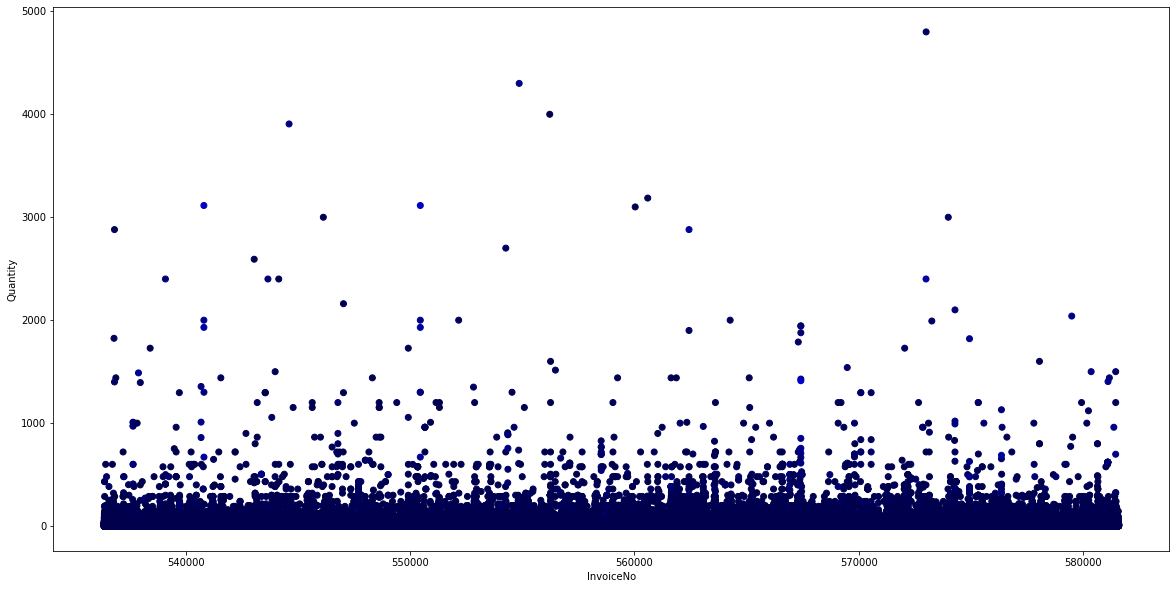

In [41]:
#After: Quantities only in the positive and with most of the outliers out of the way,
#we can see that most of the purchases are less than 1000 quantities
b = b[b['Quantity']<10000]
plt.figure(figsize=(20,10))
plt.scatter(x=b["InvoiceNo"], y=b["Quantity"], c=b["TotalPrice"], cmap='seismic')
plt.xlabel('InvoiceNo')
plt.ylabel('Quantity')

<a id="stockcodes and descriptions"></a>
2.2 Standardising StockCodes and Descriptions</a><br>
#### Next, we will clean up duplicates on StockCode vs Description
Each StockCode should have a unique Description but it is not the case in our dataset, so we will proceed to adjust it

In [42]:
data4 = b 
data4 = data4.reset_index()
data4 = data4.drop(['index','InvoiceType'], axis=1)
data4.shape

(524941, 16)

In [43]:
data4.head(5)

InvoiceNo StockCode                          Description  Quantity  \
0     536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1     536365     71053                  WHITE METAL LANTERN         6   
2     536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3     536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4     536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  CountryType  \
0 2010-12-01 08:26:00       2.55       17850  United Kingdom            1   
1 2010-12-01 08:26:00       3.39       17850  United Kingdom            1   
2 2010-12-01 08:26:00       2.75       17850  United Kingdom            1   
3 2010-12-01 08:26:00       3.39       17850  United Kingdom            1   
4 2010-12-01 08:26:00       3.39       17850  United Kingdom            1   

   TotalPrice        Date  Year  Month  Day  Weekday  Hour  
0       15.30  2010-12-01  2010     12    1        2     8  
1       20.34  2010-12-01  2010     12    1        2     8  
2       22.00  2010-12-01  2010     12    1        2     8  
3       20.34  2010-12-01  2010     12    1        2     8  
4       20.34  2010-12-01  2010     12    1        2     8

In [44]:
#Each StockCode should have a unique Description
#but it is not the case here
#We have about 152 rows to adjust
print(len(set(data4['StockCode'])))
print(len(set(data4['Description'])))
print(len(set(data4['Description'])) - len(set(data4['StockCode'])))

3923
4075
152


In [45]:
#Here we know that these StockCodes are having multiple descriptions
test=data4.groupby(['StockCode','Description']).count()
test.reset_index(inplace=True)
test.StockCode.value_counts()

23084     6
20713     6
23131     4
23209     4
23196     4
         ..
90195A    1
23515     1
90120C    1
90058A    1
22621     1
Name: StockCode, Length: 3923, dtype: int64

In [46]:
test = test[['StockCode','Description']]

In [47]:
#Most errors seem to be in lowercase
test[test['StockCode']=='23084'].Description

2112                                 Amazon
2113                     RABBIT NIGHT LIGHT
2114    add stock to allocate online orders
2115    allocate stock for dotcom orders ta
2116               for online retail orders
2117                          website fixed
Name: Description, dtype: object

In [48]:
#This is read all descriptions to see if they are in uppercases or lowercases
test['upper'] = 0
test['lower'] = 0
for i in tqdm(range(len(test))):
    string_test= test.Description[i]
    count1=0
    count2=0
    for j in string_test:
        if(j.islower()):
            count1=count1+1
        elif(j.isupper()):
            count2=count2+1
    test['upper'][i] = count2
    test['lower'][i] = count1

  0%|          | 0/4317 [00:00<?, ?it/s]/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 4317/4317 [00:00<00:00, 6560.44it/s]


We will add a "Description_test" column so that we can cross check the errors and the potentially correct ones

In [49]:
#We will create a new column to match the desired descriptions based on uppercase descriptions
#It is not a foolproof method, nor extensive. There will still be reminders that will need some manual adjustments

test['Description_test'] = 0
test['Description_test'].astype(str)

for i in tqdm(range(len(test))):
    try:
        test['Description_test'][i] = test[(test['StockCode']==test.StockCode[i]) & 
                                             (test['upper']>0) & (test['lower']==0)].Description[i]
        #If the Description is in all CAPs, ie the Original Description without error. Keep that description
    except (KeyError, IndexError):
        try:
            test['Description_test'][i] = test[(test['StockCode']==test.StockCode[i]) & 
                                                 (test['upper']>0) & (test['lower']==0)].Description[i-1]
            #If the Description NOT in all CAPs, ie the Description in this row is incorrect. Take the row above it and see if it works.
        except (KeyError, IndexError):
            try:
                test['Description_test'][i] = test[(test['StockCode']==test.StockCode[i]) & 
                                                 (test['upper']>0) & (test['lower']==0)].Description[i+1]
                #If the Description NOT in all CAPs, ie the Description in this row is incorrect. Take the row below it and see if it works.
            except (KeyError, IndexError):
                try:
                    a = test[(test['StockCode']==test.StockCode[i]) & (test['upper']>2)].Description[i]
                    test['Description_test'][i] = a.upper()
                    #Check: if there are more than 2 Caps, it is the correct Description - checked previously
                except (KeyError, IndexError):
                    try:
                        b = test[(test['StockCode']==test.StockCode[i])].Description[i]
                        test['Description_test'][i] = 0
                        #Check: if there are less than 2 Caps, there should be an error
                    except (KeyError, IndexError):
                        pass

  0%|          | 0/4317 [00:00<?, ?it/s]/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  1%|          | 40/4317 [00:00<00:10, 398.59it/s]/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/anaconda3/lib/pyth

In [50]:
#there are still about 100+ rows
print(len(set(test.StockCode)))
print(len(set(test.Description_test)))
print(len(set(test.Description_test)) - len(set(test.StockCode)))

3923
4026
103


In [51]:
#Some of the description was not corrected 
test[test['StockCode']=='23084'].Description_test

2112    RABBIT NIGHT LIGHT
2113    RABBIT NIGHT LIGHT
2114    RABBIT NIGHT LIGHT
2115                     0
2116                     0
2117                     0
Name: Description_test, dtype: object

In [52]:
#Still quite a number of rows with the same error as above
test[(test['Description_test']==0)].StockCode

56            16162M
184            20713
185            20713
186            20713
449            21181
450            21181
754            21644
868            21804
1664           22687
1714           22734
1742           22759
2115           23084
2116           23084
2117           23084
2435           23343
2714           23595
2797          35600A
2862           35965
2867           35968
2941          46000U
3596           84944
3675          85017C
3818          85135B
4296    BANK CHARGES
4306               M
4312    gift_0001_20
4316               m
Name: StockCode, dtype: object

In [53]:
test[(test['StockCode']=='85135B')]

StockCode                Description  upper  lower  \
3816    85135B  BLUE DRAGONFLY HELICOPTER     23      0   
3817    85135B                      Found      1      4   
3818    85135B                      check      0      5   

               Description_test  
3816  BLUE DRAGONFLY HELICOPTER  
3817  BLUE DRAGONFLY HELICOPTER  
3818                          0

In [54]:
#now that we have ran one round, the reminding ones should be cleaned up with this
for i in tqdm(range(len(test))):
    try:
        if test['Description_test'][i] == 0:
            test['Description_test'][i] = test['Description_test'][i-1]
    except (KeyError, IndexError):
        pass

  0%|          | 0/4317 [00:00<?, ?it/s]/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 4317/4317 [00:00<00:00, 87585.06it/s]


In [55]:
#Again, it doesn't prove to be effective
print(len(set(test.StockCode)))
print(len(set(test.Description_test)))
print(len(set(test.Description_test)) - len(set(test.StockCode)))

#but every entry is filled up (ie, no zeros in description_text)
test[(test['Description_test']==0)].StockCode

3923
4025
102


Series([], Name: StockCode, dtype: object)

In [56]:
#Doing this test again for "Description_test"
test['upper_test'] = 0
test['lower_test'] = 0
for i in tqdm(range(len(test))):
    string_test= test['Description_test'][i]
    count1=0
    count2=0
    for j in string_test:
        if(j.islower()):
            count1=count1+1
        elif(j.isupper()):
            count2=count2+1
    test['upper_test'][i] = count2
    test['lower_test'][i] = count1

  0%|          | 0/4317 [00:00<?, ?it/s]/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 4317/4317 [00:00<00:00, 6456.85it/s]


In [57]:
#To make sure everything is working corectly,
#It also serves as a visual to see how we want the errors in Desciption to be changed to Desciption_test
test[(test['Description'] != test['Description_test']) & (test['upper_test']>0)]

StockCode                          Description  upper  lower  \
2            10080                                check      0      5   
46          16151A      FLOWERS HANDBAG blue and orange     14     13   
55          16162M         THE KING GIFT BAG 25x24x12cm     14      4   
56          16162M  alan hodge cant mamage this section      0     30   
58          16168M                                found      0      5   
...            ...                                  ...    ...    ...   
4312  gift_0001_20  to push order througha s stock was       0     28   
4313  gift_0001_30  Dotcomgiftshop Gift Voucher Â£30.00      4     22   
4314  gift_0001_40  Dotcomgiftshop Gift Voucher Â£40.00      4     22   
4315  gift_0001_50  Dotcomgiftshop Gift Voucher Â£50.00      4     22   
4316             m                               Manual      1      5   

                         Description_test  upper_test  lower_test  
2                GROOVY CACTUS INFLATABLE          22           0  
46        FLOWERS HANDBAG BLUE AND ORANGE          27           0  
55           THE KING GIFT BAG 25X24X12CM          18           0  
56           THE KING GIFT BAG 25X24X12CM          18           0  
58           FUNKY MONKEY GIFT BAG MEDIUM          24           0  
...                                   ...         ...         ...  
4312  DOTCOMGIFTSHOP GIFT VOUCHER Â£20.00          26           0  
4313  DOTCOMGIFTSHOP GIFT VOUCHER Â£30.00          26           0  
4314  DOTCOMGIFTSHOP GIFT VOUCHER Â£40.00          26           0  
4315  DOTCOMGIFTSHOP GIFT VOUCHER Â£50.00          26           0  
4316  DOTCOMGIFTSHOP GIFT VOUCHER Â£50.00          26           0  

[184 rows x 7 columns]

In [58]:
#Here we will find out which are the duplicates in Description and StockCodes
one = 0
two = 0
index_two = []
three_or_more = 0
index_three =[]
error_ = []

for i in range(len(test)):
    if len(set(test[test['StockCode']==test['StockCode'][i]].Description_test)) == 1:
        one += 1
    elif len(set(test[test['StockCode']==test['StockCode'][i]].Description_test)) == 2:
        two += 1
        index_two.append(test['StockCode'][i])
    elif len(set(test[test['StockCode']==test['StockCode'][i]].Description_test)) > 2:
        three_or_more += 1
        index_three.append(test['StockCode'][i])
    else:
        error_.append(test['StockCode'][i])
        
print(one)
print(two)
print(three_or_more)
print(len(set(index_two)))
print(set(index_two))
print(len(set(index_three)))
print(set(index_three))
print(error_)

#Unique descriptions = 3835 rows
#1 duplicate = 426 rows
#2 or more duplicates = 56
#207 StockCodes that affects the 426 rows with 1 duplicate
#17 StockCodes that affects the 56 rows with 2 or more duplicates

3835
426
56
207
{'23128', '21899', '22268', '23527', '71459', '23071', '23044', '23306', '23456', '85184C', '21109', '22972', '23390', '23252', '23524', '84997c', '22804', '23168', '81950V', '23109', '22597', '23325', '23282', '21507', '22785', '23040', '23232', '23271', '90014B', '85123A', '22949', '22135', '84997b', '22632', '23523', '23197', '23388', '84828', '23324', '23691', '23342', '21243', '22950', '23041', '84997C', '72807A', '71143', '23539', '84228', '84997d', '23528', '22813', '22896', '23497', '84906', '22502', '22777', '23525', '23521', '22848', '35817P', '22925', '22812', '23091', '23020', '23299', '23253', '23391', '23250', '79051A', '23212', '23462', '84997D', '20725', '23359', '23068', '23127', '23436', '22999', '23045', '23028', '71053', '23541', '23169', '23035', '21112', '23526', '23145', '23455', '23254', '22287', '23065', '23281', '47310M', '23380', '23542', '84946', '23061', '90014C', '82001s', '23043', '20622', '82001S', '23360', '23536', '23437', '22246', '851

In [59]:
#To locate each of them individually 
#test[test['StockCode']=='84997B']

In [60]:
#AND to change them manually 
#test['Description_test'][3649] = test['Description_test'][3650]

In [61]:
#Change all StockCode to uppercase since there are minor errors within (BL and bl)
test['StockCode'] = test['StockCode'].map(lambda x: x.upper())

In [62]:
#Now we have negative values
#It means that there are 21 Descriptions where there are multiple StockCodes
print(len(set(test['StockCode'])))
print(len(set(test['Description_test'])))
print(len(set(test['Description_test'])) - len(set(test['StockCode'])))

3813
4025
212


In [63]:
test.shape

(4317, 7)

In [64]:
stockcode = test['StockCode'].astype(str)
special_stockcodes = []
for i in range(len(stockcode )):
    removed = re.sub(r'\d+', '', stockcode [i])
    if len(removed)>1 == True:
        special_stockcodes.append(removed)

print(set(special_stockcodes))
print(len(special_stockcodes))
#This will give me all the special StockCodes in each transaction

{'AMAZONFEE', 'DCGSSGIRL', 'DCGSSBOY', 'GIFT__', 'POST', 'DCGS', 'PADS', 'BL', 'DOT', 'BANK CHARGES'}
20


#### Before we head into the next section, we will quickly  export this file to save the manual changes we have made to the dataset

- test.to_csv('./data/test.csv')   #Cleaning up StockCodes and Description
- data2.to_csv('./data/data2.csv') #where quantity & total price > 0
- data4.to_csv('./data/data4.csv') #purchased made, excluding refunds

##### Below we will then remove duplicates so that each StockCode has a unique description

In [65]:
test = pd.read_csv('./data/test.csv')

In [66]:
test2=test[['StockCode','Description','Description_test']]
test2.shape

(4317, 3)

In [67]:
test2['Duplicate_S'] = test2['StockCode'].duplicated()
test2['Duplicate_Dt'] = test2['Description_test'].duplicated()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [68]:
test2[test2['StockCode'] == test2[test2['Duplicate_S'] == True].StockCode.iloc[38]]
#If the StockCode is duplicated, we can remove the duplicated rows

StockCode                   Description              Description_test  \
447     21181  PLEASE ONE PERSON METAL SIGN  PLEASE ONE PERSON METAL SIGN   
448     21181                    adjustment  PLEASE ONE PERSON METAL SIGN   
449     21181                        dotcom  PLEASE ONE PERSON METAL SIGN   
450     21181                on cargo order  PLEASE ONE PERSON METAL SIGN   

     Duplicate_S  Duplicate_Dt  
447        False         False  
448         True          True  
449         True          True  
450         True          True

In [69]:
test2 = test2[(test2['Duplicate_S']==False)]
print('Duplicates removed', 4315 - 3811)
test2.shape
#There are 3813 unique StockCodes - including those gift cards and other weird stuff
#There will be items with the SAME Description but utilising two different StockCodes 

Duplicates removed 504


(3813, 5)

<a id="Placing each stock into it's categories"></a>
3.0 Clustering each product into it's categories via NLP
### In this next section, we will use NLP to classify these products into it's categories

##### 3.1 Data Preparation for NLP

In [70]:
df_text = test2[['StockCode','Description_test']]
df_text.reset_index(inplace = True)
df_text.drop('index',axis=1,inplace = True)

In [71]:
df_text.head()

StockCode             Description_test
0     10002  INFLATABLE POLITICAL GLOBE 
1     10080     GROOVY CACTUS INFLATABLE
2     10120                 DOGGY RUBBER
3    10123C        HEARTS WRAPPING TAPE 
4    10124A  SPOTS ON RED BOOKCOVER TAPE

In [72]:
#This will pull out the first two digits of the StockCode, which will help us remove the non-products later
stockcode = df_text['StockCode'].astype(str)
numbers_stockcodes = []
df_text['CategoryCode'] = 0
for i in range(len(stockcode)):
    temp = re.findall(r'\d+', stockcode[i][0:2])
    try:
        if len(temp[0])>1:
            df_text['CategoryCode'][i] = temp
        else:
            pass
    except (IndexError, KeyError):
        pass

    
#removing them from the list to become a string
df_text['CategoryCode']= df_text['CategoryCode'].map(lambda x: x[0] if isinstance(x,list) else x)
df_text.head()   

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1214: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/anaconda3/lib/python3.7/site-packages/ipykernel_lau

StockCode             Description_test CategoryCode
0     10002  INFLATABLE POLITICAL GLOBE            10
1     10080     GROOVY CACTUS INFLATABLE           10
2     10120                 DOGGY RUBBER           10
3    10123C        HEARTS WRAPPING TAPE            10
4    10124A  SPOTS ON RED BOOKCOVER TAPE           10

In [73]:
#Those with Category Code 0 are those transactions with special indicators
df_text[df_text['CategoryCode'] == 0].head()

StockCode            Description_test CategoryCode
3793     AMAZONFEE                  AMAZON FEE            0
3794  BANK CHARGES                  AMAZON FEE            0
3795            C2                    CARRIAGE            0
3796      DCGS0003         BOXED GLASS ASHTRAY            0
3797      DCGS0004  HAYNES CAMPER SHOULDER BAG            0

In [74]:
#removing those with a CategoryCode (ie: postage, discount etc.)
df_text = df_text[df_text['CategoryCode'] != 0]
df_text.head()

StockCode             Description_test CategoryCode
0     10002  INFLATABLE POLITICAL GLOBE            10
1     10080     GROOVY CACTUS INFLATABLE           10
2     10120                 DOGGY RUBBER           10
3    10123C        HEARTS WRAPPING TAPE            10
4    10124A  SPOTS ON RED BOOKCOVER TAPE           10

In [75]:
#pre-processing for NLP
#convert all to lower case, removing numbers and punctuation, white spaces
df_text['NLP'] = 0
for i in range(len(df_text)):
    df_text['NLP'].iloc[i] = df_text['Description_test'].iloc[i].lower()
    df_text['NLP'].iloc[i] = re.sub(r'\d+', '', df_text['NLP'].iloc[i])
    df_text['NLP'].iloc[i] = df_text['NLP'].iloc[i].translate(str.maketrans('', '', string.punctuation))
    df_text['NLP'].iloc[i] = df_text['NLP'].iloc[i].strip()

In [76]:
df_text.head(2)

StockCode             Description_test CategoryCode  \
0     10002  INFLATABLE POLITICAL GLOBE            10   
1     10080     GROOVY CACTUS INFLATABLE           10   

                          NLP  
0  inflatable political globe  
1    groovy cactus inflatable

In [77]:
#Next we will remove some stopwords
stop_words = stopwords.words('english')
newStopWords = ['set','pink','blue','red','white','black','green','yellow','vintage','xxcm']
stop_words.extend(newStopWords)
filtered_sentence = []
for i in range(len(df_text)):
    word_tokens = word_tokenize(df_text['NLP'][i])
    df_text['NLP'][i] = [w for w in word_tokens if not w in stop_words]
    df_text['NLP'][i] = ' ' .join(df_text['NLP'][i])

<a id="LDA model"></a>
##### 3.1 Using Latent Dirichlet Allocation (LDA) Model to group products into categories

After some pre-processing, we will use Latent Dirichlet Allocation Model to gather 'topics' or 'categories' within each product
and classify them into groups

In [78]:
#We will be using Count Vectorizer to convert the text into vectors
#We will also use n=5 since it gives us a more balanced model and perplexity score
NUM_TOPICS = 5
 
cvec = CountVectorizer(min_df=3, max_df=0.9, 
                             stop_words='english', lowercase=True, 
                             token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
X = cvec.fit_transform(df_text['NLP'])
 
lda_model = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=1000, learning_method='online')
lda_Z = lda_model.fit_transform(X)

print(lda_model.score(X))
print(lda_model.perplexity(X))

<>:7: DeprecationWarning:

invalid escape sequence \-

<>:7: DeprecationWarning:

invalid escape sequence \-

<>:7: DeprecationWarning:

invalid escape sequence \-

<ipython-input-78-6fbfa25a02ed>:7: DeprecationWarning:

invalid escape sequence \-



-78186.19815881966
628.9768592224232


In [79]:
#Here we will print the Cluster with their top 10 most popular key words
def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Cluster %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])
 
print("LDA Model:")
print_topics(lda_model, cvec)

LDA Model:
Cluster 0:
[('glass', 148.6623611315138), ('metal', 104.76634710503437), ('necklace', 101.5662916482425), ('small', 79.11214365570267), ('earrings', 73.62755668880767), ('mug', 68.22950537688612), ('polkadot', 65.07893232971138), ('sign', 61.364342994921245), ('bowl', 51.48316700223117), ('key', 49.87725160599221)]
Cluster 1:
[('bag', 118.78624851905127), ('candle', 94.2358452938523), ('retrospot', 92.49589410095888), ('paper', 79.91755744024019), ('pack', 66.31235896024509), ('ivory', 60.54789978564301), ('mini', 55.496842422504116), ('tea', 52.53742257152309), ('love', 51.53919270017194), ('wooden', 46.49633288999896)]
Cluster 2:
[('christmas', 145.3216987892808), ('box', 125.37535967835272), ('holder', 105.88849849344044), ('hanging', 94.05180034401396), ('decoration', 92.76032966850947), ('tlight', 80.26872362170842), ('cover', 64.26007738782187), ('tree', 59.36504179272688), ('star', 52.664016315971566), ('cushion', 52.51991538348173)]
Cluster 3:
[('design', 116.6092288

In [80]:
#To get top words from each cluster
n_top_words = 100
vocab = cvec.get_feature_names()
topic_words = {}
for topic, comp in enumerate(lda_model.components_):   
    word_idx = np.argsort(comp)[::-1][:n_top_words]
    topic_words[topic] = [vocab[i] for i in word_idx]

topic_words

{0: ['glass',
  'metal',
  'necklace',
  'small',
  'earrings',
  'mug',
  'polkadot',
  'sign',
  'bowl',
  'key',
  'home',
  'frame',
  'french',
  'bead',
  'bottle',
  'photo',
  'drop',
  'antique',
  'jar',
  'hot',
  'water',
  'silver',
  'kitchen',
  'sweet',
  'feltcraft',
  'cabinet',
  'door',
  'shell',
  'dog',
  'acrylic',
  'cat',
  'floral',
  'dish',
  'crystal',
  'lantern',
  'new',
  'plate',
  'bathroom',
  'chick',
  'gold',
  'amber',
  'jam',
  'pan',
  'font',
  'folding',
  'style',
  'pendant',
  'chunky',
  'picture',
  'victorian',
  'amethyst',
  'stickers',
  'filigree',
  'hoop',
  'wood',
  'triple',
  'soap',
  'breakfast',
  'piece',
  'print',
  'enamel',
  'hanger',
  'murano',
  'pastel',
  'frying',
  'cluster',
  'candleholder',
  'beach',
  'coaster',
  'strand',
  'beaker',
  'teatime',
  'orbit',
  'twist',
  'jewel',
  'etched',
  'organiser',
  'shelf',
  'shed',
  'mint',
  'polished',
  'charlielola',
  'midnight',
  'cut',
  'candlestic

In [81]:
print(lda_Z.shape) 
print(lda_Z[20])
print(df_text['NLP'][0])

(3793, 5)
[0.06666746 0.06666748 0.73323694 0.06676065 0.06666747]
inflatable political globe


Created a few new columns:
    - Pred: the actual predicted cluster for each product
    - Pred_random: if there is a tie in probability, it will random into one of the cluster first
    - Pred_probability: the actual predicted probability
    - Shared_clusters: if it is 1, there is only one highest probability, 2 there are 2 equal probabilities in deciding which cluster the product belongs to

In [82]:
df2_text = df_text
df2_text['pred'] = 0
df2_text['pred_rand'] = 0
df2_text['pred_prob'] = 0.0
df2_text['shared_clusters'] = 0


for i in range(len(df2_text)):
    index = np.argwhere(lda_Z[i] == np.amax(lda_Z[i]))
    df2_text['pred_prob'][i] = np.amax(lda_Z[i]) #probabilty
    if len(index) == 5:
        df2_text['pred'][i] = 5
        df2_text['pred_rand'][i] = 5
        df2_text['shared_clusters'][i] = 4
    elif len(index) == 1: 
        df2_text['pred'][i] = np.argmax(lda_Z[i]) #position
        df2_text['pred_rand'][i] = int(rand.choice(index))
        df2_text['shared_clusters'][i] = 1
    else: #len 2 or 3 or 4
        df2_text['pred'][i] = np.argmax(lda_Z[i]) #position
        df2_text['shared_clusters'][i] = len(index)
        df2_text['pred_rand'][i] = int(rand.choice(index)) #if the probabilty is the same, pick a random cluster

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying 

In [83]:
#if the model is unable to predict, the probability was spread across all 5 clusters (shared with 4 other clusters)
#hence we can consider them outliers (and placed in cluster 5)

#Since there are only 1 and 4, the model is able to predict either they belong to each cluster or it's an outlier
print(set(df2_text['shared_clusters']))
df2_text.groupby('pred').count()

{1, 4}


StockCode  Description_test  CategoryCode  NLP  pred_rand  pred_prob  \
pred                                                                         
0           775               775           775  775        775        775   
1           766               766           766  766        766        766   
2           770               770           770  770        770        770   
3           730               730           730  730        730        730   
4           737               737           737  737        737        737   
5            15                15            15   15         15         15   

      shared_clusters  
pred                   
0                 775  
1                 766  
2                 770  
3                 730  
4                 737  
5                  15

In [84]:
df2_text.head()

StockCode             Description_test CategoryCode  \
0     10002  INFLATABLE POLITICAL GLOBE            10   
1     10080     GROOVY CACTUS INFLATABLE           10   
2     10120                 DOGGY RUBBER           10   
3    10123C        HEARTS WRAPPING TAPE            10   
4    10124A  SPOTS ON RED BOOKCOVER TAPE           10   

                          NLP  pred  pred_rand  pred_prob  shared_clusters  
0  inflatable political globe     5          5   0.200000                4  
1    groovy cactus inflatable     0          0   0.599972                1  
2                doggy rubber     0          0   0.599980                1  
3        hearts wrapping tape     4          4   0.733332                1  
4        spots bookcover tape     4          4   0.733329                1

<a id="Post-prediction analysis"></a>
##### 3.2 Post-prediction analysis


After some pre-processing, we will use Latent Dirichlet Allocation Model to gather 'topics' or 'categories' within each product
and classify them into groups

<a id="Post-prediction analysis1"></a>
##### 3.2.1 Interactive Plot to show each key words

Using an interactive plot from pyLDA,we can review each cluster's keywords and it's relevant terms

In [85]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, X, cvec, mds='tsne')
panel

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1      -58.756130 -251.437210       1        1  20.765882
0     -153.238907    1.587135       2        1  20.602478
2      211.966980   -6.344356       3        1  20.015783
3       40.905762  203.670746       4        1  19.319154
4      220.294556 -277.093872       5        1  19.296703, topic_info=    Category        Freq       Term       Total  loglift  logprob
382  Default  202.000000      heart  202.000000  30.0000  30.0000
168  Default  137.000000  christmas  137.000000  29.0000  29.0000
354  Default  136.000000      glass  136.000000  28.0000  28.0000
86   Default  118.000000        box  118.000000  27.0000  27.0000
315  Default  109.000000     flower  109.000000  26.0000  26.0000
..       ...         ...        ...         ...      ...      ...
274   Topic5   38.398099     easter   46.162364   1.4611  -4.1104
673   Topic5   69.207321       rose   92.609392   1.3540  -3.5213
214   Topic5   31.163890    crystal   48.906618   1.1946  -4.3192
721   Topic5   30.358310     silver   76.193994   0.7250  -4.3454
363   Topic5   20.036058       gold   36.255858   1.0522  -4.7609

[199 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2         2  0.985546   acrylic
15        2  0.981312   antique
20        5  0.990696       art
24        1  0.678483  assorted
24        5  0.311735  assorted
...     ...       ...       ...
876       1  0.983894      wire
878       1  0.991545    wooden
883       5  0.980049      wrap
888       3  0.727504      zinc
888       5  0.258147      zinc

[177 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 4, 5])

<a id="Post-prediction analysis2"></a>
##### 3.2.2 PCA Plot to show each cluster on a 2D plot

Using a PCA, we can have a rough idea on the positions of each clusters in the 2D space

Text(0, 0.5, 'cumulative % of explained variance')

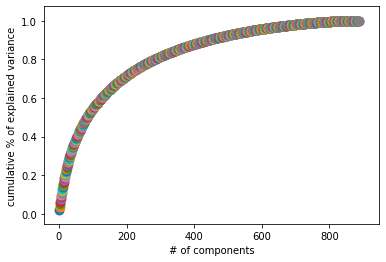

In [86]:
#we also plot PCA to showcase the different clusters
#unfortunately, we will need well over 500 PC's to explain over 90% of the data
pca = PCA()
X_pca = pca.fit_transform(X.todense())
X_pca = pd.DataFrame(X_pca, 
                     columns=['PC'+str(i+1) for i in range(X.shape[1])],
                     index=df_text['NLP'].index)

for i in range(1,len(pca.explained_variance_ratio_)):
    plt.scatter(i, sum(pca.explained_variance_ratio_[:i]), s=80)
plt.xlabel("# of components")
plt.ylabel('cumulative % of explained variance')

/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning:

The `size` parameter has been renamed to `height`; pleaes update your code.



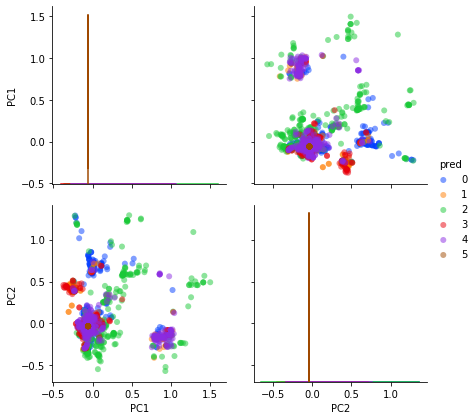

In [87]:
X_pca['pred'] = df2_text['pred']
sns.pairplot(data=X_pca, 
             vars=['PC1','PC2'], 
             hue='pred',
             palette='bright',
             size=3,
             plot_kws={'edgecolor':'None',
                       'alpha':0.5});

<a id="Post-prediction analysis3"></a>
##### 3.2.3 Word cloud on all clusters

We are also able to visualise the key words from each clusters using wordcloud

In [162]:
cluster0 = []
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
#since cluster 5 is anything that is out of the first 5 clusters
#we need to pull out the words from elsewhere
cvec2 = CountVectorizer(min_df=1, max_df=0.9, 
                             stop_words='english', lowercase=True, 
                             token_pattern='[a-zA-Z][a-zA-Z]{2,}')

X2 = df2_text[df2_text['pred']==5].NLP
X2_trans = cvec2.fit_transform(X2)
cluster5 = cvec2.get_feature_names()

for i in range(len(topic_words[0])):
    cluster0.append(topic_words[0][i])
    cluster1.append(topic_words[1][i])
    cluster2.append(topic_words[2][i])
    cluster3.append(topic_words[3][i])
    cluster4.append(topic_words[4][i])
    
cluster0 = ' ' .join(cluster0)
cluster1 = ' ' .join(cluster1)
cluster2 = ' ' .join(cluster2)
cluster3 = ' ' .join(cluster3)
cluster4 = ' ' .join(cluster4)
cluster5 = ' ' .join(cluster5)

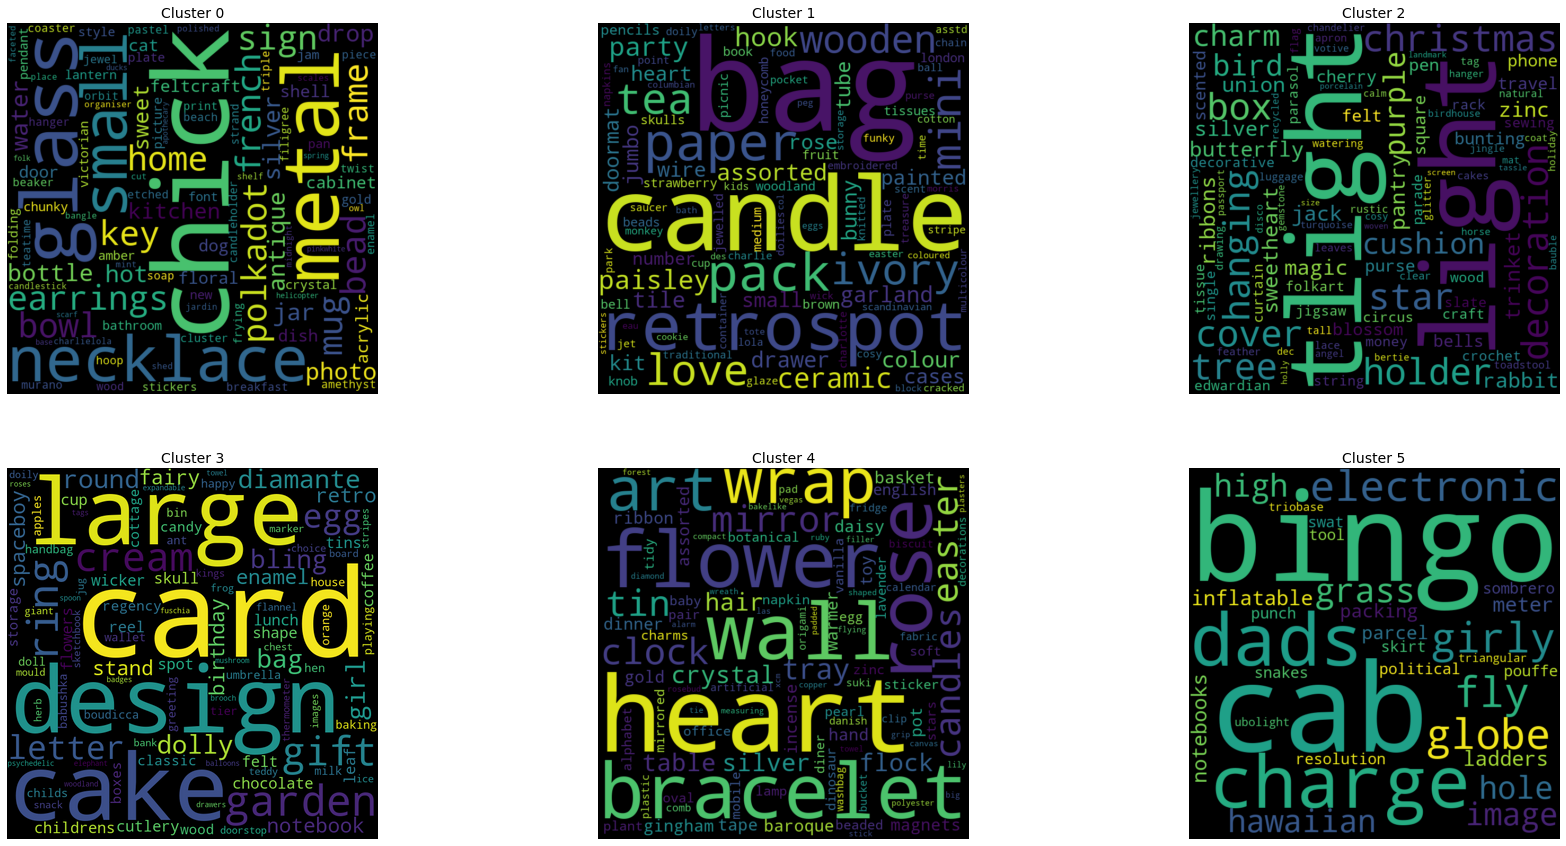

In [165]:
plt.figure(figsize = (30,15))

ax1 = plt.subplot(231)
ax1.set_title('Cluster 0', fontsize=14)
wordcloud = WordCloud(width = 700, height = 700, 
                background_color ='black', 
                min_font_size = 10).generate(cluster0) 
plt.imshow(wordcloud,interpolation='bilinear') 
plt.axis("off") 
  
ax2 = plt.subplot(232)
ax2.set_title('Cluster 1', fontsize=14)
wordcloud = WordCloud(width = 700, height = 700, 
                background_color ='black', 
                min_font_size = 10).generate(cluster1) 
plt.imshow(wordcloud,interpolation='bilinear') 
plt.axis("off") 

ax3 = plt.subplot(233)
ax3.set_title('Cluster 2', fontsize=14)
wordcloud = WordCloud(width = 700, height = 700, 
                background_color ='black', 
                min_font_size = 10).generate(cluster2) 
plt.imshow(wordcloud,interpolation='bilinear') 
plt.axis("off") 


ax4 = plt.subplot(234)
ax4.set_title('Cluster 3', fontsize=14)
wordcloud = WordCloud(width = 700, height = 700, 
                background_color ='black', 
                min_font_size = 10).generate(cluster3) 
plt.imshow(wordcloud,interpolation='spline36') 
plt.axis("off") 

ax5 = plt.subplot(235)
ax5.set_title('Cluster 4', fontsize=14)
wordcloud = WordCloud(width = 700, height = 700, 
                background_color ='black', 
                min_font_size = 10).generate(cluster4) 
plt.imshow(wordcloud,interpolation='bilinear') 
plt.axis("off") 

ax6 = plt.subplot(236)
ax6.set_title('Cluster 5', fontsize=14)
wordcloud = WordCloud(width = 700, height = 700, 
                background_color ='black', 
                min_font_size = 10).generate(cluster5) 
plt.imshow(wordcloud,interpolation='bilinear') 
plt.axis("off") 

plt.show()

In [90]:
#we will use get dummies to binarize the clusters
df3_text = df2_text.drop(['CategoryCode','NLP','pred_rand','pred_prob','shared_clusters'], axis=1)
df3_text = pd.concat([df3_text.drop('pred', axis=1), pd.get_dummies(df3_text['pred'])], axis=1)
df3_text.columns = ['StockCode','Desciption_test','cluster0','cluster1','cluster2','cluster3','cluster4','cluster5']

Saving this file first<br>
df3_text.to_csv('./data/test_postNLP.csv') #post NLP

<a id="Feature Selection"></a>
##### 4.0 Selecting the features needed for the classification

### In this section, we will look at the customers.

The first part is to map our product data back into the main dataset

In [91]:
df3_text = pd.read_csv('./data/test_postNLP.csv')
data4 = pd.read_csv('./data/data4.csv')

In [92]:
df3_text.head(2)

Unnamed: 0 StockCode              Desciption_test  cluster0  cluster1  \
0           0     10002  INFLATABLE POLITICAL GLOBE          0         0   
1           1     10080     GROOVY CACTUS INFLATABLE         0         0   

   cluster2  cluster3  cluster4  cluster5  
0         0         0         0         1  
1         1         0         0         0

In [93]:
data4.shape

(524941, 17)

In [94]:
data4.head(2)

Unnamed: 0  InvoiceNo StockCode                         Description  \
0           0     536365    85123A  WHITE HANGING HEART T-LIGHT HOLDER   
1           1     536365     71053                 WHITE METAL LANTERN   

   Quantity          InvoiceDate  UnitPrice  CustomerID         Country  \
0         6  2010-12-01 08:26:00       2.55       17850  United Kingdom   
1         6  2010-12-01 08:26:00       3.39       17850  United Kingdom   

   CountryType  TotalPrice        Date  Year  Month  Day  Weekday  Hour  
0            1       15.30  2010-12-01  2010     12    1        2     8  
1            1       20.34  2010-12-01  2010     12    1        2     8

In [95]:
df3_text.drop(['Unnamed: 0'], axis=1, inplace=True)
d = df3_text.set_index('StockCode').T.to_dict('list')

#Change all StockCode to uppercase to reduce mapping error
data4['StockCode'] = data4['StockCode'].map(lambda x: x.upper())
data4['df_text']=data4['StockCode'].map(d)
data4['df_text'].fillna(0,inplace=True)
data4.drop(['Unnamed: 0'], axis=1,inplace=True)

d_list = df3_text.columns

<a id="Feature Selection1"></a>
##### 4.1 Feature Selection
    - adding weights to the purchase amounts
    - keeping and reformatting the information of extra charges such as delivery cost etc

In [96]:
#unpack the dictionary from df3_text to data4
data4['Desciption_test'] = 0
data4['cluster0'] = 0
data4['cluster1'] = 0
data4['cluster2'] = 0
data4['cluster3'] = 0
data4['cluster4'] = 0
data4['cluster5'] = 0

for i in tqdm(range(len(data4))):
    if data4['df_text'][i] == 0:
        data4['Desciption_test'][i] = 0
        data4['cluster0'][i] = 0
        data4['cluster1'][i] = 0
        data4['cluster2'][i] = 0
        data4['cluster3'][i] = 0
        data4['cluster4'][i] = 0
        data4['cluster5'][i] = 0
    else:
        data4['Desciption_test'][i] = data4['df_text'][i][0]
        data4['cluster0'][i] = data4['df_text'][i][1]
        data4['cluster1'][i] = data4['df_text'][i][2]
        data4['cluster2'][i] = data4['df_text'][i][3]
        data4['cluster3'][i] = data4['df_text'][i][4]
        data4['cluster4'][i] = data4['df_text'][i][5]
        data4['cluster5'][i] = data4['df_text'][i][6]       

  0%|          | 0/524941 [00:00<?, ?it/s]/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:202: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22:

In [97]:
#adding weights to each purchased categories

def adding_weights(data):
    data.cluster0 = data.cluster0.astype(float)
    data.cluster1 = data.cluster1.astype(float)
    data.cluster2 = data.cluster2.astype(float)
    data.cluster3 = data.cluster3.astype(float)
    data.cluster4 = data.cluster4.astype(float)
    data.cluster5 = data.cluster5.astype(float)
    for i in tqdm(range(len(data))):
        if data.cluster0[i] != 0:
            data.cluster0[i] = data.TotalPrice[i]
        if data.cluster1[i] != 0:
            data.cluster1[i] = data.TotalPrice[i]
        if data.cluster2[i] != 0:
            data.cluster2[i] = data.TotalPrice[i]
        if data.cluster3[i] != 0:
            data.cluster3[i] = data.TotalPrice[i]
        if data.cluster4[i] != 0:
            data.cluster4[i] = data.TotalPrice[i]
        if data.cluster5[i] != 0:
            data.cluster5[i] = data.TotalPrice[i]
    return data

adding_weights(data4)

  0%|          | 0/524941 [00:00<?, ?it/s]/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: Se

InvoiceNo StockCode                          Description  Quantity  \
0          536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1          536365     71053                  WHITE METAL LANTERN         6   
2          536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3          536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4          536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...           ...       ...                                  ...       ...   
524936     581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
524937     581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
524938     581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
524939     581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
524940     581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

                InvoiceDate  UnitPrice  CustomerID         Country  \
0       2010-12-01 08:26:00       2.55       17850  United Kingdom   
1       2010-12-01 08:26:00       3.39       17850  United Kingdom   
2       2010-12-01 08:26:00       2.75       17850  United Kingdom   
3       2010-12-01 08:26:00       3.39       17850  United Kingdom   
4       2010-12-01 08:26:00       3.39       17850  United Kingdom   
...                     ...        ...         ...             ...   
524936  2011-12-09 12:50:00       0.85       12680          France   
524937  2011-12-09 12:50:00       2.10       12680          France   
524938  2011-12-09 12:50:00       4.15       12680          France   
524939  2011-12-09 12:50:00       4.15       12680          France   
524940  2011-12-09 12:50:00       4.95       12680          France   

        CountryType  TotalPrice  ... Weekday  Hour  \
0                 1       15.30  ...       2     8   
1                 1       20.34  ...       2     8   
2                 1       22.00  ...       2     8   
3                 1       20.34  ...       2     8   
4                 1       20.34  ...       2     8   
...             ...         ...  ...     ...   ...   
524936            0       10.20  ...       4    12   
524937            0       12.60  ...       4    12   
524938            0       16.60  ...       4    12   
524939            0       16.60  ...       4    12   
524940            0       14.85  ...       4    12   

                                                  df_text  \
0       [WHITE HANGING HEART T-LIGHT HOLDER, 0, 1, 0, ...   
1        [WHITE MOROCCAN METAL LANTERN, 0, 0, 0, 0, 1, 0]   
2       [CREAM CUPID HEARTS COAT HANGER, 0, 0, 0, 0, 1...   
3       [KNITTED UNION FLAG HOT WATER BOTTLE, 0, 0, 0,...   
4       [RED WOOLLY HOTTIE WHITE HEART., 0, 0, 1, 0, 0...   
...                                                   ...   
524936    [PACK OF 20 SPACEBOY NAPKINS, 0, 0, 1, 0, 0, 0]   
524937   [CHILDREN'S APRON DOLLY GIRL , 0, 0, 0, 1, 0, 0]   
524938       [KIDS CUTLERY DOLLY GIRL , 0, 0, 0, 1, 0, 0]   
524939  [CHILDRENS CUTLERY CIRCUS PARADE, 0, 0, 0, 1, ...   
524940  [BAKING SET 9 PIECE RETROSPOT , 0, 0, 1, 0, 0, 0]   

                            Desciption_test  cluster0  cluster1 cluster2  \
0        WHITE HANGING HEART T-LIGHT HOLDER       0.0      15.3     0.00   
1              WHITE MOROCCAN METAL LANTERN       0.0       0.0     0.00   
2            CREAM CUPID HEARTS COAT HANGER       0.0       0.0     0.00   
3       KNITTED UNION FLAG HOT WATER BOTTLE       0.0       0.0     0.00   
4            RED WOOLLY HOTTIE WHITE HEART.       0.0       0.0    20.34   
...                                     ...       ...       ...      ...   
524936          PACK OF 20 SPACEBOY NAPKINS       0.0       0.0    10.20   
524937         CHILDREN'S APRON DOLLY GIRL        0.0       0.0     0.00   
524938             KIDS CUTLERY DOLLY GIRL        0.0       0.0     0.00   
524939      CHILDRENS CUTLERY CIRCUS PARADE       0.0       0.0     0.00   
524940      

In [98]:
data4['sum'] = data4.iloc[:,18:24].sum(axis=1)
data4[data4['sum'] == 0].shape

(2943, 25)

In [99]:
data4[data4['sum'] == 0].shape

(2943, 25)

There are 2943 rows which dont fit into any of the 5 clusters. <br>
Upon investigation, those are the transactions which includes special codes within them.<br>
We will group them into buckets and then subsequently remove these rows<br>

In [100]:
#groupA = ['POST', 'C2', 'DOT', 'M' ] #Delivery
#groupB = ['BANK CHARGES','AMAZONFEE'] #Extra charges
#groupC = ['Gift', 'S', 'PADS', 'DCGS'] #Other purchases
#groupD = ['DCGS'] #group together with cluster 5

In [101]:
#First we will create new columns for them
#then sum them up based on their characteristics
#remove columns in temp_list
temp_list = ['POST', 'C2', 'DOT', 'M','BANK CHARGES','AMAZONFEE','Gift', 'S', 'PADS','DCGS']
for i in tqdm(range(len(temp_list))):
    data4[temp_list[i]] = 0  
    specialcode_index = data4[data4['StockCode'].str.contains(temp_list[i])].index
    for j in tqdm(range(len(data4[data4['StockCode'].str.contains(temp_list[i])]))):
        temp_index = data4[data4['InvoiceNo'] == data4[data4['StockCode'].str.contains(temp_list[i])].InvoiceNo.iloc[j]].index
        for k in range(len(temp_index)):
            data4[temp_list[i]][temp_index[k]] = data4['TotalPrice'][ specialcode_index[j]]

  0%|          | 0/1126 [00:00<?, ?it/s]/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


 13%|█▎        | 146/1126 [00:27<03:00,  5.44it/s]


 26%|██▋       | 297/1126 [00:55<02:34,  5.38it/s]


 40%|███▉      | 448/1126 [01:23<02:11,  5.15it/s]


 53%|█████▎    | 599/1126 [01:51<01:45,  4.98it/s]


 67%|██████▋   | 750/1126 [02:19<01:05,  5.72it/s]


 80%|████████  | 901/1126 [02:47<00:39,  5.69it/s]


 93%|█████████▎| 1051/1126 [03:14<00:15,  4.82it/s]


 55%|█████▍    | 77/141 [00:13<00:11,  5.56it/s]


 13%|█▎        | 92/708 [00:18<02:05,  4.93it/s]


 35%|███▍      | 246/708 [00:47<01:36,  4.80it/s]


 56%|█████▋    | 400/708 [01:16<00:59,  5.16it/s]


 78%|███████▊  | 554/708 [01:44<00:30,  4.99it/s]


 30%|███       | 3/10 [06:11<17:21, 148.77s/it]s]


 20%|██        | 155/760 [00:28<01:52,  5.39it/s]


 41%|████      | 309/760 [00:57<01:21,  5.54it/s]


 61%|██████    | 463/760 [01:25<00:57,  5.12it/s]


 81%|████████  | 617/760 [01:53<00:26,  5.49it/s]


 92%|█████████▏| 11/12 [00:01<00:00,  5.82it/s]


  5%|▌         | 148/2883 [00:28<08:25,  5.41it/s]


 10%|█         | 299/2883 [00:57<08:04,  5.33it/s]


 16%|█▌        | 450/2883 [01:27<07:34,  5.36it/s]


 21%|██        | 601/2883 [01:55<07:00,  5.42it/s]


 26%|██▌       | 752/2883 [02:23<06:21,  5.59it/s]


 31%|███▏      | 903/2883 [02:51<06:10,  5.34it/s]


 37%|███▋      | 1053/2883 [03:19<05:55,  5.15it/s]


 42%|████▏     | 1201/2883 [03:47<05:08,  5.46it/s]


 47%|████▋     | 1349/2883 [04:15<04:35,  5.56it/s]


 52%|█████▏    | 1497/2883 [04:42<04:20,  5.32it/s]


 57%|█████▋    | 1645/2883 [05:10<03:49,  5.38it/s]


 62%|██████▏   | 1793/2883 [05:38<03:21,  5.41it/s]


 67%|██████▋   | 1941/2883 [06:05<03:01,  5.19it/s]


 72%|███████▏  | 2089/2883 [06:32<02:26,  5.41it/s]


 78%|███████▊  | 2237/2883 [06:59<01:53,  5.68it/s]


 83%|████████▎ | 2385/2883 [07:25<01:28,  5.63it/s]


 88%|████████▊ | 2533/2883 [07:53<01:06,  5.28it/s]


 93%|█████████▎| 2681/2883 [08:20<00:35,  5.72it/s]


 98%|█████████▊| 2829/2883 [08:48<00:10,  5.11it/s]


100%|██████████| 10/10 [17:44<00:00, 99.07s/it]


In [102]:
#This is for ['DCGS']
temp_list = ['DCGS']
for i in tqdm(range(len(temp_list))):
    data4[temp_list[i]] = 0  
    specialcode_index = data4[data4['StockCode'].str.contains(temp_list[i])].index
    for k in range(len(specialcode_index)):
        data4[temp_list[i]][specialcode_index[k]] = data4['TotalPrice'][specialcode_index[k]]
        data4['cluster5'][specialcode_index[k]] = data4['TotalPrice'][specialcode_index[k]]

  0%|          | 0/1 [00:00<?, ?it/s]/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


In [103]:
#groupA = ['POST', 'C2', 'DOT', 'M' ] #Delivery
#groupB = ['BANK CHARGES','AMAZONFEE'] #Extra charges
#groupC = ['Gift', 'S', 'PADS'] #Other purchases

#update the ['sum'] column again
data4['Delivery_Charges'] = data4.iloc[:,25:29].sum(axis=1)
data4['Extra_Charges'] = data4.iloc[:,29:31].sum(axis=1)
data4['Other Purchases'] = data4.iloc[:,31:34].sum(axis=1)
data4['sum'] = data4.iloc[:,18:24].sum(axis=1)

In [104]:
data4.drop(['Country','df_text','POST', 'C2', 'DOT', 'M','BANK CHARGES','AMAZONFEE','Gift', 'S', 'PADS', 'DCGS'], axis=1, inplace=True)

In [105]:
#we only want those with purchased made
data5 = data4[(data4['sum'] != 0) & (data4['Quantity']>0)]

Before we head into the next section, we will quickly export this file to save the work done with our dateset
- data5.to_csv('./data/data5.csv')

In [106]:
data5 = pd.read_csv('./data/data5.csv', index_col=0)

In [107]:
data5.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'CountryType', 'TotalPrice', 'Date', 'Year',
       'Month', 'Day', 'Weekday', 'Hour', 'Desciption_test', 'cluster0',
       'cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5', 'sum',
       'DCGS', 'Delivery_Charges', 'Extra_Charges', 'Other Purchases'],
      dtype='object')

In [108]:
data5.head(1)

InvoiceNo StockCode                         Description  Quantity  \
0     536365    85123A  WHITE HANGING HEART T-LIGHT HOLDER         6   

           InvoiceDate  UnitPrice  CustomerID  CountryType  TotalPrice  \
0  2010-12-01 08:26:00       2.55       17850            1        15.3   

         Date  ...  cluster1  cluster2  cluster3  cluster4  cluster5   sum  \
0  2010-12-01  ...      15.3       0.0       0.0       0.0       0.0  15.3   

   DCGS  Delivery_Charges  Extra_Charges  Other Purchases  
0     0                 0              0                0  

[1 rows x 27 columns]

<a id="Groupby InvoiceNo and CustomerID"></a>
##### 4.2 Groupby InvoiceNo and CustomerID

#### First, we group by Invoice to stack all invoices together to form full receipts 

In [109]:
Transaction = data5.groupby('InvoiceNo').agg({'CustomerID':'max',
                                              'CountryType':'max',
                                              'Quantity':'sum',
                                              'InvoiceDate':'max',
                                              'Month':'max',
                                              'Day':'max',
                                              'Weekday':'max',
                                              'Hour':'max',
                                              'cluster0':'sum',
                                              'cluster1':'sum',
                                              'cluster2':'sum',
                                              'cluster3':'sum',
                                              'cluster4':'sum',
                                              'cluster5':'sum',
                                              'sum':'sum',
                                              'Delivery_Charges':'max',
                                              'Extra_Charges':'max',
                                              'Other Purchases':'max'})

In [110]:
Transaction.head(2)

CustomerID  CountryType  Quantity          InvoiceDate  Month  Day  \
InvoiceNo                                                                       
536365          17850            1        34  2010-12-01 08:26:00     12    1   
536366          17850            1         6  2010-12-01 08:28:00     12    1   

           Weekday  Hour  cluster0  cluster1  cluster2  cluster3  cluster4  \
InvoiceNo                                                                    
536365           2     8       0.0      15.3     20.34     35.64     42.34   
536366           2     8       0.0       0.0      0.00     11.10      0.00   

           cluster5     sum  Delivery_Charges  Extra_Charges  Other Purchases  
InvoiceNo                                                                      
536365          0.0  113.62                 0              0                0  
536366          0.0   11.10                 0              0                0

In [111]:
Transaction['PricePerQuantity'] = Transaction['sum']/Transaction['Quantity']
Transaction.reset_index(inplace=True)
Transaction.InvoiceDate = pd.to_datetime(Transaction.InvoiceDate)

In [112]:
Transaction.head(1)

InvoiceNo  CustomerID  CountryType  Quantity         InvoiceDate  Month  \
0     536365       17850            1        34 2010-12-01 08:26:00     12   

   Day  Weekday  Hour  cluster0  cluster1  cluster2  cluster3  cluster4  \
0    1        2     8       0.0      15.3     20.34     35.64     42.34   

   cluster5     sum  Delivery_Charges  Extra_Charges  Other Purchases  \
0       0.0  113.62                 0              0                0   

   PricePerQuantity  
0          3.341765

#### Next, we grouping by Customer to stack all receipts together to form full purchase history

In [113]:
Customer = Transaction.groupby(['CustomerID']).agg({'InvoiceNo':'count',
                                                    'CountryType':'max',
                                                    'Quantity':'sum',
                                                    'Weekday':'mean',
                                                    'Hour':'mean',
                                                    'cluster0':'sum',
                                                    'cluster1':'sum',
                                                    'cluster2':'sum',
                                                    'cluster3':'sum',
                                                    'cluster4':'sum',
                                                    'cluster5':'sum',
                                                    'sum':'sum',
                                                    'Delivery_Charges':'sum',
                                                    'Extra_Charges':'sum',
                                                    'Other Purchases':'sum'})

In [114]:
Customer.head(10)

InvoiceNo  CountryType  Quantity   Weekday       Hour  cluster0  \
CustomerID                                                                    
12347               7            0      2458  1.714286  12.285714   1020.18   
12348               4            0      2332  2.750000  13.000000      0.00   
12349               1            0       630  0.000000   9.000000    242.99   
12350               1            0       196  2.000000  16.000000     15.00   
12352               7            0       526  1.857143  14.285714    158.30   
12353               1            0        20  3.000000  17.000000      0.00   
12354               1            0       530  3.000000  13.000000     96.15   
12355               1            0       240  0.000000  13.000000     51.00   
12356               3            0      1573  2.666667   9.666667     90.40   
12357               1            0      2708  6.000000  16.000000    952.28   

            cluster1  cluster2  cluster3  cluster4  cluster5      sum  \
CustomerID                                                              
12347         754.98   1229.90    996.55    308.39       0.0  4310.00   
12348          17.00    312.24    913.60    194.40       0.0  1437.24   
12349         103.53    469.15    387.99    253.89       0.0  1457.55   
12350          25.20    152.70     33.70     67.80       0.0   294.40   
12352         167.78    129.15    613.66    316.85       0.0  1385.74   
12353          31.50      0.00     57.50      0.00       0.0    89.00   
12354          81.80    431.07    317.08    153.30       0.0  1079.40   
12355           0.00     85.20    323.20      0.00       0.0   459.40   
12356         147.92   1222.88    907.48    118.75       0.0  2487.43   
12357         384.00   2067.36   2220.72    583.31       0.0  6207.67   

            Delivery_Charges  Extra_Charges  Other Purchases  
CustomerID                                                    
12347                      0              0                0  
12348                    360              0              360  
12349                    300              0              300  
12350                     40              0               40  
12352                    280              0              280  
12353                      0              0                0  
12354                      0              0                0  
12355                      0              0                0  
12356                    324              0              324  
12357                      0              0                0

In [115]:
Customer['AvgPricePerInvoice'] = Customer['sum']/Customer['InvoiceNo']
Customer['AvgQuantityPerInvoice'] = Customer['Quantity']/Customer['InvoiceNo']
Customer['AvgDeliveryPerInvoice'] = Customer['Delivery_Charges']/Customer['InvoiceNo']
Customer['AvgExtraChargePerInvoice'] = Customer['Extra_Charges']/Customer['InvoiceNo']
Customer['AvgOtherPurchasePerInvoice'] = Customer['Other Purchases']/Customer['InvoiceNo']
Customer.reset_index(inplace=True)

In [116]:
Customer.head()

CustomerID  InvoiceNo  CountryType  Quantity   Weekday       Hour  \
0       12347          7            0      2458  1.714286  12.285714   
1       12348          4            0      2332  2.750000  13.000000   
2       12349          1            0       630  0.000000   9.000000   
3       12350          1            0       196  2.000000  16.000000   
4       12352          7            0       526  1.857143  14.285714   

   cluster0  cluster1  cluster2  cluster3  ...  cluster5      sum  \
0   1020.18    754.98   1229.90    996.55  ...       0.0  4310.00   
1      0.00     17.00    312.24    913.60  ...       0.0  1437.24   
2    242.99    103.53    469.15    387.99  ...       0.0  1457.55   
3     15.00     25.20    152.70     33.70  ...       0.0   294.40   
4    158.30    167.78    129.15    613.66  ...       0.0  1385.74   

   Delivery_Charges  Extra_Charges  Other Purchases  AvgPricePerInvoice  \
0                 0              0                0          615.714286   
1               360              0              360          359.310000   
2               300              0              300         1457.550000   
3                40              0               40          294.400000   
4               280              0              280          197.962857   

   AvgQuantityPerInvoice  AvgDeliveryPerInvoice  AvgExtraChargePerInvoice  \
0             351.142857                    0.0                       0.0   
1             583.000000                   90.0                       0.0   
2             630.000000                  300.0                       0.0   
3             196.000000                   40.0                       0.0   
4              75.142857                   40.0                       0.0   

   AvgOtherPurchasePerInvoice  
0                         0.0  
1                        90.0  
2                       300.0  
3                        40.0  
4                        40.0  

[5 rows x 21 columns]

In [117]:
#Creating four new columns for each customer
Customer['FirstPurchase'] = 0
Customer['LastPurchase'] = 0
Customer['AvgDaysPerInvoice'] = 0
Customer['DaysSinceLastPurchase'] = 0

for i in tqdm(range(len(Customer))):
    Customer['FirstPurchase'][i] = Transaction[Transaction['CustomerID'] == Customer['CustomerID'][i]].InvoiceDate.min()
    Customer['LastPurchase'][i] = Transaction[Transaction['CustomerID'] == Customer['CustomerID'][i]].InvoiceDate.max()
    Customer['AvgDaysPerInvoice'][i] = (Customer['LastPurchase'][i] - Customer['FirstPurchase'][i]).days/Customer['InvoiceNo'][i]
    Customer['DaysSinceLastPurchase'][i] = (Transaction['InvoiceDate'].max() - Customer['LastPurchase'][i]).days

  0%|          | 0/5703 [00:00<?, ?it/s]/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: Settin

In [118]:
#Find Registered Members
Customer['RegisteredMember'] = 0
for i in tqdm(range(len(Customer))):
    if Customer['CustomerID'][i] < 100000:
        Customer['RegisteredMember'][i] = 1

  0%|          | 0/5703 [00:00<?, ?it/s]/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 5703/5703 [00:00<00:00, 18790.65it/s]


In [119]:
#Customers with only one order
print(len(Customer))
print(Customer[Customer['InvoiceNo']==1].InvoiceNo.count()/len(Customer))
print(Customer[(Customer['RegisteredMember']==1)].InvoiceNo.count()/len(Customer))
print(Customer[(Customer['InvoiceNo']==1) & (Customer['RegisteredMember']==1)].InvoiceNo.count()/Customer[Customer['RegisteredMember']==1].InvoiceNo.count())

#5703 unique customers
#50% of total customers only has 1 order with the company
#76% of customers are registered (24% are non-registered)
#34% of registered customers only has 1 order with the company

5703
0.5046466771874452
0.7596002104155708
0.347876269621422


In [120]:
Transaction.to_csv('./data/Transaction.csv')
Customer.to_csv('./data/Customer.csv')

<a id="Classifying"></a>
### 5.0 Classifying Customers via Agglomerative Clustering

Up till now, we have created quite a few features.(and the column names might have a different meaning after groupbys), so before we go into modelling, we will summarise all the columns and it's meaning as a refresher.


|Customer (Column names)| Description | Unit |
|----------------|----------------|-----------|
| InvoiceNo | Total Number of Invoices purchased by a particular customer | Int |
| CountryType | Country of Purchase, 1 = UK, 0 = Non-UK | Int |
|Quantity | Total Number of Items purchased by a particular customer | Int |
|Weekday | Average Day of purchase by the Customer, 0 = Monday, 6 = Sunday | Float | 
|Hour | Average Hour of the day purchases were made, 24 hour time | Float |
|cluster0 | Total amount customer purchased for items in cluster 0, in dollars | Float |
|cluster1 | Total amount customer purchased for items in cluster 1, in dollars | Float |
|cluster2 | Total amount customer purchased for items in cluster 2, in dollars | Float |
|cluster3 | Total amount customer purchased for items in cluster 3, in dollars | Float |
|cluster4 | Total amount customer purchased for items in cluster 4, in dollars | Float |
|cluster5 | Total amount customer purchased for items in cluster 5, in dollars | Float |
|sum | Total amount customer purchased for items, in dollars | Float |
|Delivery_Charges | Total amount customer paid for delivery, in dollars | Float |
|Extra_Charges | Total amount customer paid for extra charges (bank charge etc), in dollars | Float |
|Other Purchases | Total amount customer paid for other purchases (DSCG listing), in dollars | Float |
|AvgPricePerInvoice | Average amount customer purchased per Invoice, in dollars | Float |
|AvgQuantityPerInvoice | Average quantity customer purchased per Invoice, in dollars | Float |
|AvgDeliveryPerInvoice | Average delivery cost per Invoice, in dollars | Float |
|AvgExtraChargePerInvoice | Average amount of charges per Invoice, in dollars | Float |
|AvgOtherPurchasePerInvoice | Average amount other purchases per Invoice, in dollars | Float |
|AvgDaysPerInvoice | Average number of days per transaction was made, lower number of days, the better| Float |
|DaysSinceLastPurchase | Number of days since their last purchase, lower number of days = more recent | Float
|RegisteredMember | 1 = Registered Member, 0 = Non-Registered Member| Int |




In [121]:
Transaction = pd.read_csv('./data/Transaction.csv', index_col=0)
Customer = pd.read_csv('./data/Customer.csv', index_col=0)

In [122]:
Customer.columns

Index(['CustomerID', 'InvoiceNo', 'CountryType', 'Quantity', 'Weekday', 'Hour',
       'cluster0', 'cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5',
       'sum', 'Delivery_Charges', 'Extra_Charges', 'Other Purchases',
       'AvgPricePerInvoice', 'AvgQuantityPerInvoice', 'AvgDeliveryPerInvoice',
       'AvgExtraChargePerInvoice', 'AvgOtherPurchasePerInvoice',
       'FirstPurchase', 'LastPurchase', 'AvgDaysPerInvoice',
       'DaysSinceLastPurchase', 'RegisteredMember'],
      dtype='object')

In [123]:
X = Customer.drop(['CustomerID','FirstPurchase','LastPurchase',], axis=1)
ss = StandardScaler()
Xs = ss.fit_transform(X)

In [124]:
clustering = AgglomerativeClustering(n_clusters=5,affinity='euclidean', linkage='ward').fit(Xs)
print(clustering.n_clusters_)
print(clustering.n_leaves_)
print(clustering.n_connected_components_)
print(len(clustering.children_))
print(set(clustering.labels_))

5
5703
1
5702
{0, 1, 2, 3, 4}


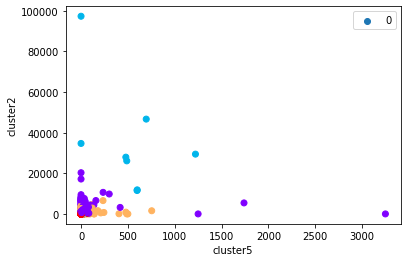

In [125]:
plt.scatter(X.iloc[:,10],X.iloc[:,7], c=clustering.labels_, cmap='rainbow')
plt.xlabel(X.columns[10])
plt.ylabel(X.columns[7])
plt.legend([0,1,2,3,4])

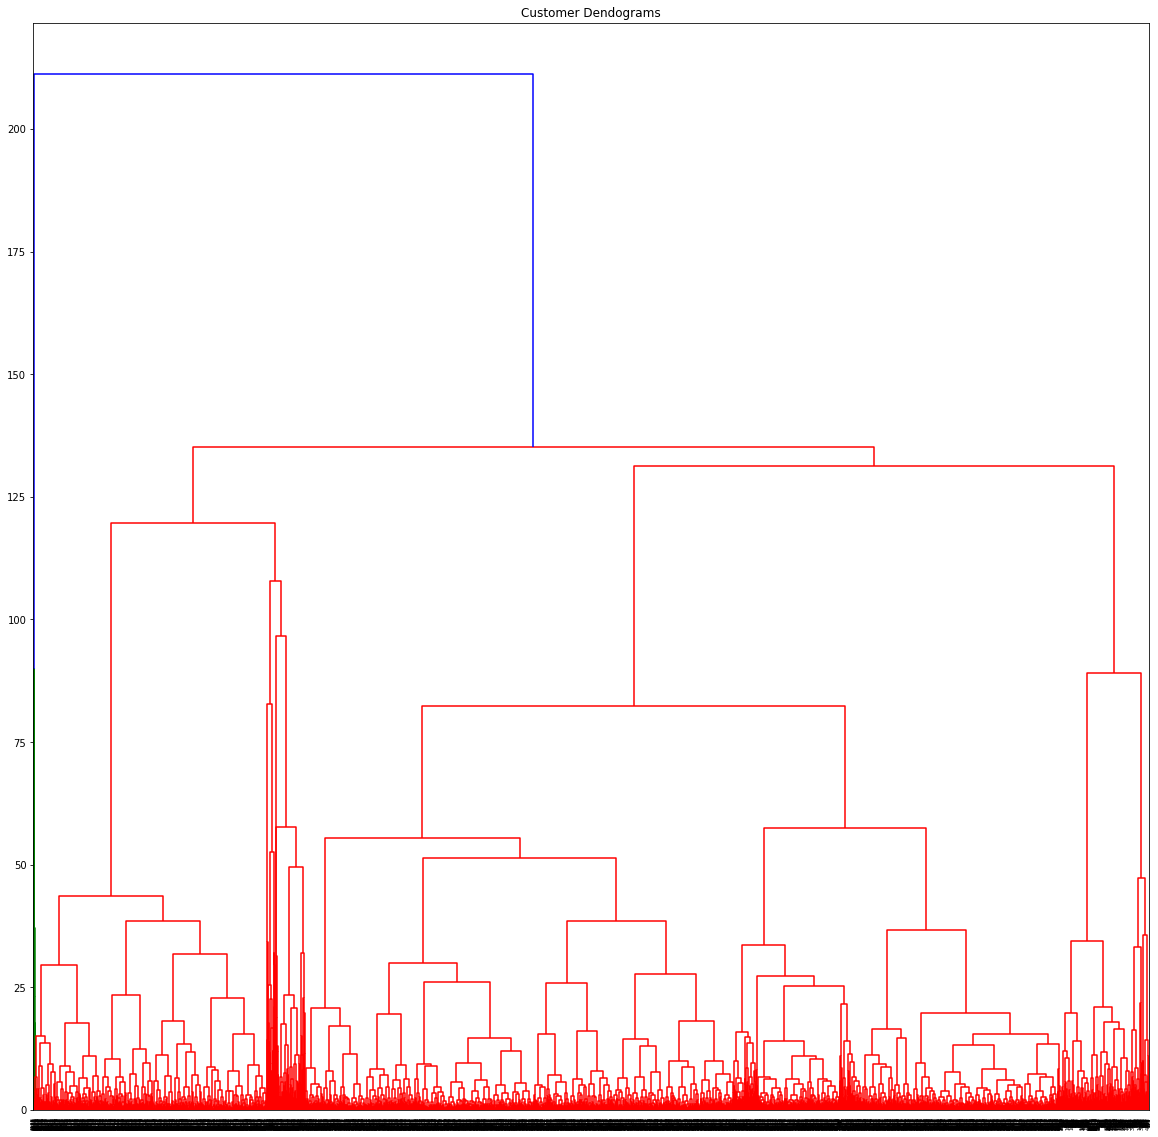

In [166]:
plt.figure(figsize=(20, 20))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(Xs, method='ward'))

<a id="Classifying1"></a>

### 5.1 Training a supervised model to predict future customers via a Decision Tree
##### After getting the results from the unsupervised training, we will then train a supervised model to predict future customers 

##### We will select between Decision Trees, Random Forest, Logistic Regression, K-Nearest Neighbour, Adaboost and BaggingClassifier for this

In [127]:
Customer['class'] = clustering.fit_predict(Xs)
y = Customer['class']
X_train, X_test, y_train, y_test = train_test_split(Xs,
                                                    y,
                                                    random_state=42,
                                                    train_size=0.7)

In [128]:
model = []
parameters = []
scores = []
precision = []
recall = []

# To put the name of model, models from sklearn, and hyperparameters of the model we want to search through in order

names = ['Decision Tree', 'RandomForest', 'LogReg','KNN','SVC','AdaBoost', 'BaggingClass']

estimators = [DecisionTreeClassifier(), RandomForestClassifier(), LogisticRegression(), KNeighborsClassifier(),
             SVC(), AdaBoostClassifier(), BaggingClassifier()]

params = [
    {'clf__max_depth': [None, 10, 15, 20, 30, 35],
    'clf__min_samples_split': [5,10,15,20,25,30]}, #DecisionTree

    {'clf__max_depth': [None,50,75,100,150,200],
     'clf__min_samples_split': [5,10,15,20,30]}, #RandomForest
    
    {'clf__C':[1,3,5,10],
     'clf__solver':['lbfgs', 'liblinear', 'sag', 'saga'],
     'clf__max_iter':[50,100,125,150,175,200]}, #LogisticRegression
    
    {'clf__n_neighbors':[3,5,10,15,20,25],
     'clf__weights':['uniform','distance'],
     'clf__p':[1,2,3]}, #KNeighborsClassifier
    
    {'clf__kernel':['rbf']}, #SVC - 'something wrong with 'sigmoid','poly','linear'
    
    {'clf__n_estimators':[25,40,50,100,200,500]}, #AdaBoost
    
    {'clf__n_estimators':[10,30,50,100],
     'clf__max_samples':[1,5,10],
     'clf__max_features':[1,5,10]}, #BaggingClassifier
]

for name, estimator, param in zip(names, estimators, params):
    clf_pipe = Pipeline([
        # not sure if we need to scale the X
        # removed ('ss', StandardScaler),
        ('clf', estimator)
    ])
#     cv = StratifiedKFold(shuffle=True, n_splits=3)
    cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
    gs = GridSearchCV(clf_pipe, param_grid=param, cv=cv, verbose=10, n_jobs=-1)
    gs.fit(X_train, y_train)
    
    print(name)
    print('Best Score: {}'.format(gs.best_score_))
    print('Best Params: {}'.format(gs.best_params_))
    
    # Best Model
    grid_model = gs.best_estimator_
    
    print('Model Score on X_train: {}'.format(grid_model.score(X_train, y_train)))
    
    # Prediction and score
    pred = grid_model.predict(X_test)
    print('Accuracy score of prediction: {}'.format(accuracy_score(y_test, pred)))
    
    
    # Confusion Matrix 
    
    conf_matrix = multilabel_confusion_matrix(y_test, pred, labels=[0,1,2,3,4])
    
    tn = conf_matrix[:, 0, 0]
    tp = conf_matrix[:, 1, 1]
    fn = conf_matrix[:, 1, 0]
    fp = conf_matrix[:, 0, 1]
    
    print('TN: {}, FP:{}, FN:{}, TP:{}'.format(tn,fp,fn,tp))
    print('Precision of the model is {}'. format(tp/(tp+fp)))
    print('Recall of the model is {}'.format(tp/(tp+fn)))
   
    
    print('\n')
    model.append(name)
    parameters.append(gs.best_params_)
    scores.append(accuracy_score(y_test, pred))
    recall.append(tp/(tp+fn))
    precision.append(tp/(tp+fp))

results = pd.DataFrame({'model': model, 
              'parameters': parameters, 
              'scores': scores, 
              'recall': recall, 
              'precision': precision,
                       })
results

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1942s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  85 out of 108 | elapsed:    3.4s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  96 out of 108 | elapsed:    3.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Decision Tree
Best Score: 0.9908218606591572
Best Params: {'clf__max_depth': None, 'clf__min_samples_split': 30}
Model Score on X_train: 0.9954909819639278
Accuracy score of prediction: 0.9929865575686733
TN: [1644 1710 1553  580 1345], FP:[4 0 2 4 2], FN:[5 0 2 4 1], TP:[  58    1  154 1123  363]
Precision of the model is [0.93548387 1.         0.98717949 0.99645075 0.99452055]
Recall of the model is [0.92063492 1.         0.98717949 0.99645075 0.99725275]


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0872s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.8s finished
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


RandomForest
Best Score: 0.9945765540258656
Best Params: {'clf__max_depth': 50, 'clf__min_samples_split': 10}
Model Score on X_train: 0.9974949899799599
Accuracy score of prediction: 0.9959088252483927
TN: [1645 1710 1553  582 1347], FP:[3 0 2 2 0], FN:[2 0 0 4 1], TP:[  61    1  156 1123  363]
Precision of the model is [0.953125   1.         0.98734177 0.99822222 1.        ]
Recall of the model is [0.96825397 1.         1.         0.99645075 0.99725275]


Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:   12.5s
[Paralle

LogReg
Best Score: 0.9916562369628703
Best Params: {'clf__C': 10, 'clf__max_iter': 50, 'clf__solver': 'lbfgs'}
Model Score on X_train: 0.9952404809619239
Accuracy score of prediction: 0.9929865575686733
TN: [1645 1710 1553  579 1345], FP:[3 0 2 5 2], FN:[7 0 0 4 1], TP:[  56    1  156 1123  363]
Precision of the model is [0.94915254 1.         0.98734177 0.99556738 0.99452055]
Recall of the model is [0.88888889 1.         1.         0.99645075 0.99725275]


Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1807s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  74 out of 108 | elapsed:    3.2s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  96 out of 108 | elapsed:    4.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    5.5s finished


KNN
Best Score: 0.9933249895702962
Best Params: {'clf__n_neighbors': 3, 'clf__p': 1, 'clf__weights': 'distance'}
Model Score on X_train: 1.0
Accuracy score of prediction: 0.9970777323202805
TN: [1648 1710 1553  583 1345], FP:[0 0 2 1 2], FN:[3 0 0 2 0], TP:[  60    1  156 1125  364]
Precision of the model is [1.         1.         0.98734177 0.9991119  0.99453552]
Recall of the model is [0.95238095 1.         1.         0.99822538 1.        ]


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0472s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning:

invalid value encountered in true_divide

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning:

invalid value encountered in true_divide

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


SVC
Best Score: 0.9933249895702962
Best Params: {'clf__kernel': 'rbf'}
Model Score on X_train: 0.998496993987976
Accuracy score of prediction: 0.9953243717124488
TN: [1644 1710 1554  584 1344], FP:[4 0 1 0 3], FN:[3 1 0 4 0], TP:[  60    0  156 1123  364]
Precision of the model is [0.9375            nan 0.99363057 1.         0.99182561]
Recall of the model is [0.95238095 0.         1.         0.99645075 1.        ]


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done   3 out of  18 | elapsed:    0.2s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   5 out of  18 | elapsed:    0.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    0.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   9 out of  18 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    1.0s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:    1.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    1.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    3.3s finished
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning:

invalid value encountered in true_divide

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning:

invalid value encountered in true_divide

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks

AdaBoost
Best Score: 0.8940342094284522
Best Params: {'clf__n_estimators': 25}
Model Score on X_train: 0.8935370741482966
Accuracy score of prediction: 0.8714202220923437
TN: [1647 1710 1555  426 1286], FP:[  1   0   0 158  61], FN:[ 63   1 156   0   0], TP:[   0    0    0 1127  364]
Precision of the model is [0.                nan        nan 0.8770428  0.85647059]
Recall of the model is [0. 0. 0. 1. 1.]


Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done   8 out of 108 | elapsed:    0.1s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  19 out of 108 | elapsed:    0.3s remaining:    1.3s


BaggingClass
Best Score: 0.8702544847726325
Best Params: {'clf__max_features': 10, 'clf__max_samples': 10, 'clf__n_estimators': 100}
Model Score on X_train: 0.8684869739478958
Accuracy score of prediction: 0.8340151957919345
TN: [1648 1710 1555  344 1303], FP:[  0   0   0 240  44], FN:[ 63   1 156   0  64], TP:[   0    0    0 1127  300]
Precision of the model is [       nan        nan        nan 0.82443307 0.87209302]
Recall of the model is [0.         0.         0.         1.         0.82417582]




[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.7s finished
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning:

invalid value encountered in true_divide

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning:

invalid value encountered in true_divide



model                                         parameters    scores  \
0  Decision Tree  {'clf__max_depth': None, 'clf__min_samples_spl...  0.992987   
1   RandomForest  {'clf__max_depth': 50, 'clf__min_samples_split...  0.995909   
2         LogReg  {'clf__C': 10, 'clf__max_iter': 50, 'clf__solv...  0.992987   
3            KNN  {'clf__n_neighbors': 3, 'clf__p': 1, 'clf__wei...  0.997078   
4            SVC                             {'clf__kernel': 'rbf'}  0.995324   
5       AdaBoost                          {'clf__n_estimators': 25}  0.871420   
6   BaggingClass  {'clf__max_features': 10, 'clf__max_samples': ...  0.834015   

                                              recall  \
0  [0.9206349206349206, 1.0, 0.9871794871794872, ...   
1  [0.9682539682539683, 1.0, 1.0, 0.9964507542147...   
2  [0.8888888888888888, 1.0, 1.0, 0.9964507542147...   
3  [0.9523809523809523, 1.0, 1.0, 0.9982253771073...   
4  [0.9523809523809523, 0.0, 1.0, 0.9964507542147...   
5                          [0.0, 0.0, 0.0, 1.0, 1.0]   
6           [0.0, 0.0, 0.0, 1.0, 0.8241758241758241]   

                                           precision  
0  [0.9354838709677419, 1.0, 0.9871794871794872, ...  
1  [0.953125, 1.0, 0.9873417721518988, 0.99822222...  
2  [0.9491525423728814, 1.0, 0.9873417721518988, ...  
3  [1.0, 1.0, 0.9873417721518988, 0.9991119005328...  
4  [0.9375, nan, 0.9936305732484076, 1.0, 0.99182...  
5  [0.0, nan, nan, 0.8770428015564202, 0.85647058...  
6  [nan, nan, nan, 0.8244330651060717, 0.87209302...

##### Since the results are most quite consistent, we will select Decision Tree since it is simple to implement and high interpretability

In [129]:
dtree = DecisionTreeClassifier()
dtree.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

<a id="Classifying2"></a>

### 5.1.1 Decision Tree Results (Visual and Report)
##### We will then visualise the Decision Tree report and also in it's text form to see how classes are being formed


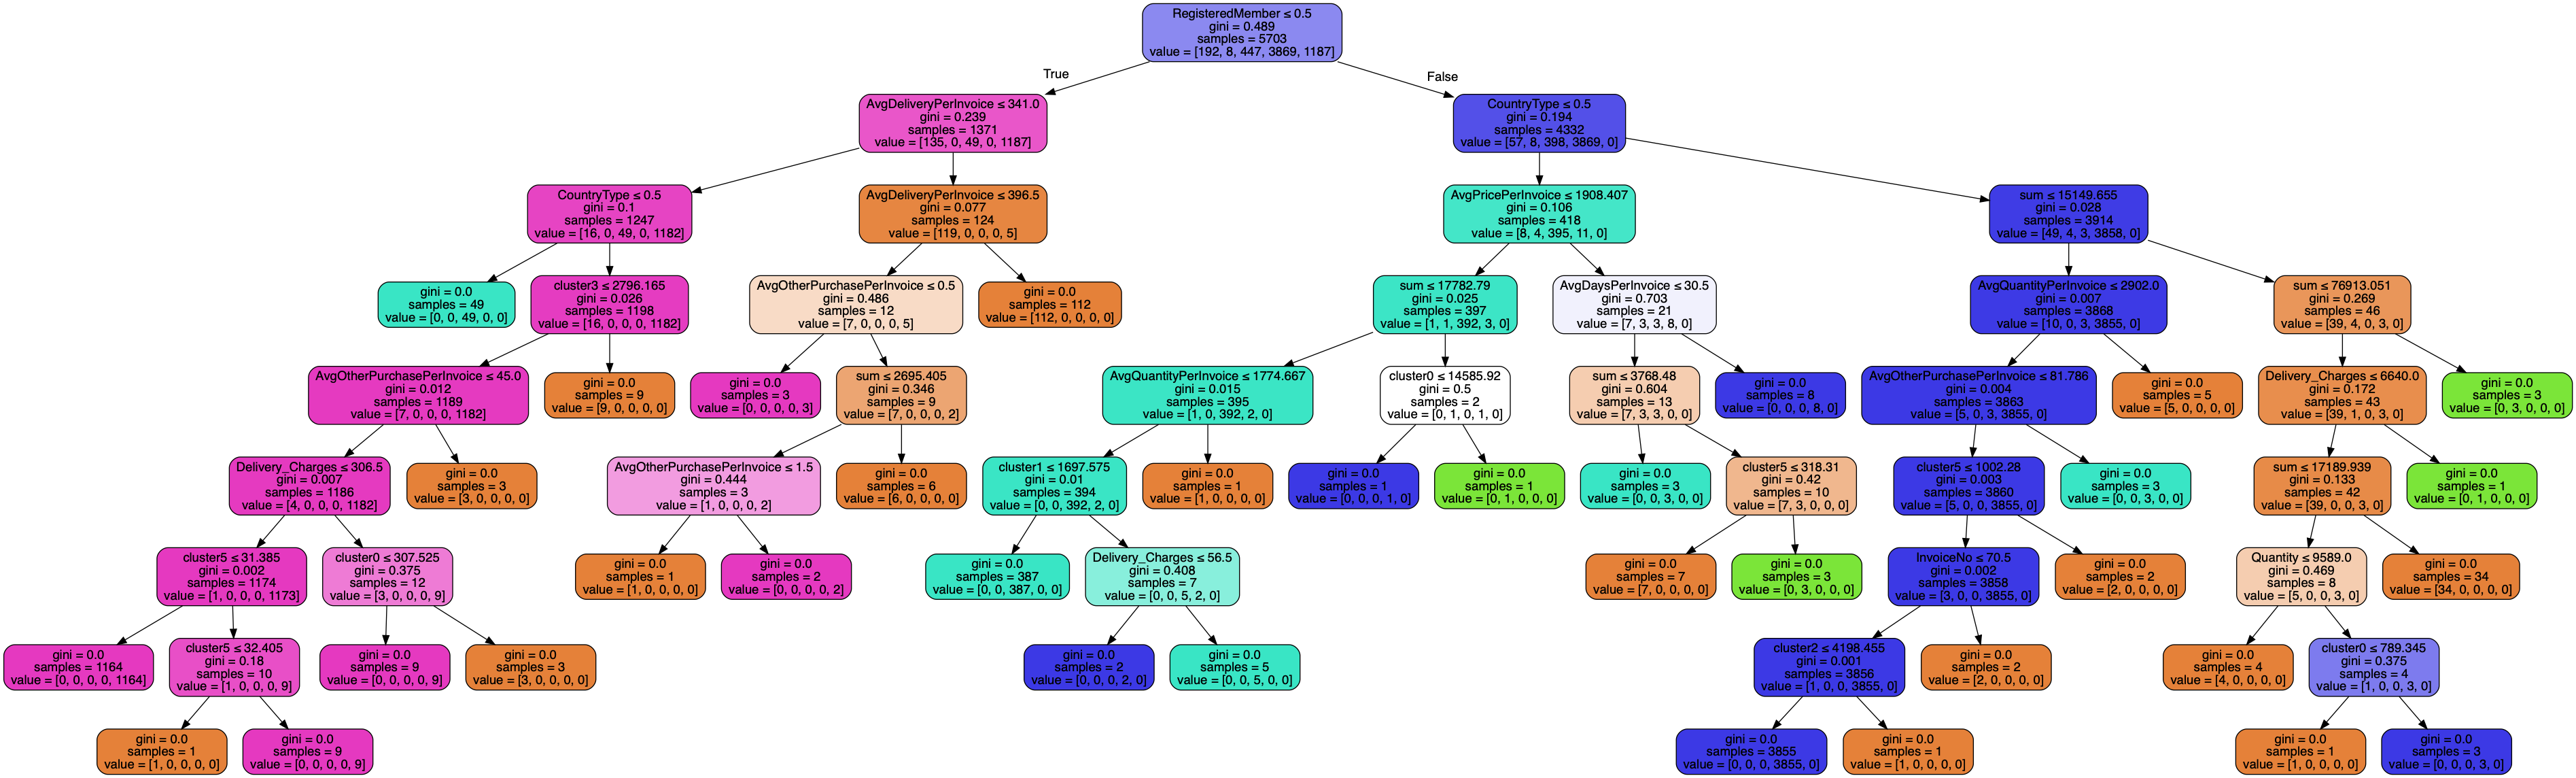

In [130]:
dot_data = StringIO()  

export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
               feature_names=X.columns)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [131]:
from sklearn.tree.export import export_text
r = export_text(dtree, feature_names=list(X.columns))
print(r)

|--- RegisteredMember <= 0.50
|   |--- AvgDeliveryPerInvoice <= 341.00
|   |   |--- CountryType <= 0.50
|   |   |   |--- class: 2
|   |   |--- CountryType >  0.50
|   |   |   |--- cluster3 <= 2796.16
|   |   |   |   |--- AvgOtherPurchasePerInvoice <= 45.00
|   |   |   |   |   |--- Delivery_Charges <= 306.50
|   |   |   |   |   |   |--- cluster5 <= 31.38
|   |   |   |   |   |   |   |--- class: 4
|   |   |   |   |   |   |--- cluster5 >  31.38
|   |   |   |   |   |   |   |--- cluster5 <= 32.40
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- cluster5 >  32.40
|   |   |   |   |   |   |   |   |--- class: 4
|   |   |   |   |   |--- Delivery_Charges >  306.50
|   |   |   |   |   |   |--- cluster0 <= 307.53
|   |   |   |   |   |   |   |--- class: 4
|   |   |   |   |   |   |--- cluster0 >  307.53
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- AvgOtherPurchasePerInvoice >  45.00
|   |   |   |   |   |--- class: 0
|   |   |   |--- cluster3 >  2796.16
|

<a id="Classifying3"></a>

### 5.2 Conclusion

We have now classified these customers into 5 main classes.

    -Class 0: Heavy occasional customers: Low frequency, higher spenders, Low Transaction counts, high spendings
    -Class 1: Loyalist: Key Customers, biggest spenders, orders weekly 
    -Class 2: Occasional customers: Low frequency, low spenders, Registered customers but in relatively 
    low quantities, mostly overseas
    -Class 3: Light loyal customer: Registered customers but in relatively low quantities, all local
    -Class 4: Trialist: first time customers, low spendings, mostly in low quantity
    
With this information, we are able to dig deeper into each classes and see each of their habits so that we can now
target specfic marketing efforts tailored for them. (e.g new product launch)

An example will be how to better retain customers or to send a discount code or free delivery only to class 4 to get them to sign up. Or a loyalty program to reward class 1 since they are your biggest spender so far and wish to retain them.

An extension to this project will be a recommender systems to better recommend simliar or complementary products to the respective customers.
##### Lastly, the below shows the radar plot for the different classes and some of the attributes that shows their importance to the company

In [132]:
fig = make_subplots(rows=3, cols=2, specs=[[{'type': 'polar'}]*2]*3,
                   subplot_titles=("CLASS 0", "CLASS 1", "CLASS 2", "CLASS 3", "CLASS 4"))

fig.add_trace(go.Scatterpolar(
      name = "CLASS 0",
      r = [1, 1, 5, 4, 1],
      theta = ["Invoice Count", "Registered Member", "Avg Price", "Avg Quantity", "Avg Days"],
    ), 1, 1)
fig.add_trace(go.Scatterpolar(
      name = "CLASS 1",
      r = [5, 5, 5, 5, 5],
      theta = ["Invoice Count", "Registered Member", "Avg Price", "Avg Quantity", "Avg Days"],
    ), 1, 2)
fig.add_trace(go.Scatterpolar(
      name = "CLASS 2",
      r = [2, 4, 3, 3, 3],
      theta = ["Invoice Count", "Registered Member", "Avg Price", "Avg Quantity", "Avg Days"],
    ), 2, 1)
fig.add_trace(go.Scatterpolar(
      name = "CLASS 3",
      r = [2, 5, 4, 2, 2],
      theta = ["Invoice Count", "Registered Member", "Avg Price", "Avg Quantity", "Avg Days"],
    ), 2, 2)

fig.add_trace(go.Scatterpolar(
      name = "CLASS 4",
      r = [0, 0, 2, 1, 1],
      theta = ["Invoice Count", "Registered Member", "Avg Price", "Avg Quantity", "Avg Days"],
    ), 3, 1)

fig.update_traces(fill='toself')
fig.update_layout(
    polar = dict(
      radialaxis = dict(
        angle = 180,
        tickangle = -180 # so that tick labels are not upside down
    )),
    polar2 = dict(
      radialaxis = dict(
        angle = 180,
        tickangle = -180 # so that tick labels are not upside down
      )),
    polar3 = dict(
      radialaxis = dict(
        angle = 180,
        tickangle = -180 # so that tick labels are not upside down
    )),
    polar4 = dict(
      radialaxis = dict(
        angle = 180,
        tickangle = -180 # so that tick labels are not upside down
    )),
    polar5 = dict(
      radialaxis = dict(
        angle = 180,
        tickangle = -180 # so that tick labels are not upside down
    )))

fig.update_layout(height=1200, width=800, title_text="Radar Plots for Each Class")
fig.show()

In [178]:
#Exporting for deployment
from joblib import dump
filename = 'final_model.joblib'
joblib.dump(dtree, filename)

['final_model.joblib']

In [175]:
# Sample Customer to try out the model
print("You can try it out yourself to see which class you belong to")
RegisteredMember = int(input("Are you a registered member? Key 1 for Yes, 0 for No"))
InvoiceNo = int(input("How many times have you purchased here? Key 1 if you wish to be random"))
CountryType = int(input("Are you from the UK? Key 1 for Yes, 0 for No"))
Quantity = int(input("Total Quantity you have purchased? Integers please"))
Weekday = random.randint(0,6)
Hour = random.randint(6,20)
cluster0 = float(input("How much did you buy from cluster0? In dollars"))
cluster1 = float(input("How much did you buy from cluster1? In dollars"))
cluster2 = float(input("How much did you buy from cluster2? In dollars"))
cluster3 = float(input("How much did you buy from cluster3? In dollars"))
cluster4 = float(input("How much did you buy from cluster4? In dollars"))
cluster5 = float(input("How much did you buy from cluster5? In dollars"))
total_sum = cluster0 + cluster1 + cluster2 + cluster3 + cluster4 + cluster5
Delivery_Charges = float(input("Were there any Delivery charge? In dollars"))
Extra_Charges = float(input("Were there any other charges? In dollars"))
Other_Purchases = float(input("Were there any other purchases? In dollars"))
AvgPricePerInvoice = total_sum / InvoiceNo
AvgQuantityPerInvoice = Quantity / InvoiceNo
AvgDeliveryPerInvoice = Delivery_Charges / InvoiceNo
AvgExtraChargePerInvoice =  Extra_Charges / InvoiceNo
AvgOtherPurchasePerInvoice = Other_Purchases / InvoiceNo
AvgDaysPerInvoice = random.randint(0,120)
DaysSinceLastPurchase = int(input("When was your last purchase? Key in days"))

sample_customer = np.array([InvoiceNo,
                            CountryType,
                            Quantity,
                            Weekday,
                            Hour,
                            cluster0,
                            cluster1,
                            cluster2,
                            cluster3,
                            cluster4,
                            cluster5,
                            total_sum,
                            Delivery_Charges,
                            Extra_Charges,
                            Other_Purchases,
                            AvgPricePerInvoice,
                            AvgQuantityPerInvoice,
                            AvgDeliveryPerInvoice,
                            AvgExtraChargePerInvoice,
                            AvgOtherPurchasePerInvoice,
                            AvgDaysPerInvoice,
                            DaysSinceLastPurchase,
                            RegisteredMember])
sample_customer = sample_customer.reshape(1,-1) 
customer_class = dtree.predict(sample_customer)
print("You belong to class {}".format(customer_class))

You can try it out yourself to see which class you belong to
Are you a registered member? Key 1 for Yes, 0 for No1
How many times have you purchased here? Key 1 if you wish to be random5
Are you from the UK? Key 1 for Yes, 0 for No1
Total Quantity you have purchased? Integers please699
How much did you buy from cluster0? In dollars52
How much did you buy from cluster1? In dollars52
How much did you buy from cluster2? In dollars577
How much did you buy from cluster3? In dollars12
How much did you buy from cluster4? In dollars123
How much did you buy from cluster5? In dollars232
Were there any Delivery charge? In dollars456
Were there any other charges? In dollars223
Were there any other purchases? In dollars123
When was your last purchase? Key in days566
You belong to class [3]
